<a href="https://colab.research.google.com/github/commingseo/code_project/blob/main/Box_office_data_ipynb_%EB%B6%84%EC%84%9D%EC%9E%90%EB%A3%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data를 통해 Box_office의 수익을 바탕으로 성공요인과 실패요인을 측정하고 영화의 수익을 예측한다.


In [70]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [334]:
!pip install shap

     |████████████████████████████████| 371 kB 14.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for shap: filename=shap-0.40.0-cp37-cp37m-linux_x86_64.whl size=509239 sha256=7e6953bdc7642d235ff1200d0c8c1cd1de0c2e2f82f3e2480ce4a081cacdf7a6
  Stored in directory: /root/.cache/pip/wheels/ec/35/84/e304841ac4b910bc95fe9a6e5302eb2507b4333728851dcbfb
Successfully built shap


In [335]:
import pandas as pd
import numpy as np
from numpy import mean
import time
from datetime import datetime
import calendar
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import re
from scipy.stats import pearsonr
import math
from statistics import median
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
import xgboost as xgb
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error, accuracy_score
import shap
plt.style.use('ggplot')
pd.options.mode.chained_assignment = None  # default='warn'

In [71]:
import sys
import pandas as pd
import numpy as np
from numpy import mean
import time
from datetime import datetime
import calendar
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import re
from scipy.stats import pearsonr

train = pd.read_csv("/content/drive/MyDrive/code_bootsdata/box_office/train.csv")
test = pd.read_csv("/content/drive/MyDrive/code_bootsdata/box_office/test.csv")

In [72]:
train_features = []
log_features = []
cols_to_drop = []

In [73]:
#train data 확인
train.head(3)

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000


In [74]:
test.head(3)

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew
0,3001,"[{'id': 34055, 'name': 'Pokémon Collection', '...",0,"[{'id': 12, 'name': 'Adventure'}, {'id': 16, '...",http://www.pokemon.com/us/movies/movie-pokemon...,tt1226251,ja,ディアルガVSパルキアVSダークライ,Ash and friends (this time accompanied by newc...,3.851534,/tnftmLMemPLduW6MRyZE0ZUD19z.jpg,NaN,"[{'iso_3166_1': 'JP', 'name': 'Japan'}, {'iso_...",7/14/07,90.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Somewhere Between Time & Space... A Legend Is ...,Pokémon: The Rise of Darkrai,"[{'id': 11451, 'name': 'pok√©mon'}, {'id': 115...","[{'cast_id': 3, 'character': 'Tonio', 'credit_...","[{'credit_id': '52fe44e7c3a368484e03d683', 'de..."
1,3002,NaN,88000,"[{'id': 27, 'name': 'Horror'}, {'id': 878, 'na...",NaN,tt0051380,en,Attack of the 50 Foot Woman,When an abused wife grows to giant size becaus...,3.559789,/9MgBNBqlH1sG4yG2u4XkwI5CoJa.jpg,"[{'name': 'Woolner Brothers Pictures Inc.', 'i...","[{'iso_3166_1': 'US', 'name': 'United States o...",5/19/58,65.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A titanic beauty spreads a macabre wave of hor...,Attack of the 50 Foot Woman,"[{'id': 9748, 'name': 'revenge'}, {'id': 9951,...","[{'cast_id': 2, 'character': 'Nancy Fowler Arc...","[{'credit_id': '55807805c3a3685b1300060b', 'de..."
2,3003,NaN,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",NaN,tt0118556,en,Addicted to Love,Good-natured astronomer Sam is devastated when...,8.085194,/ed6nD7h9sbojSWY2qrnDcSvDFko.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",5/23/97,100.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A Comedy About Lost Loves And Last Laughs,Addicted to Love,"[{'id': 931, 'name': 'jealousy'}, {'id': 9673,...","[{'cast_id': 11, 'character': 'Maggie', 'credi...","[{'credit_id': '52fe4330c3a36847f8041367', 'de..."


In [75]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3000 non-null   int64  
 1   belongs_to_collection  604 non-null    object 
 2   budget                 3000 non-null   int64  
 3   genres                 2993 non-null   object 
 4   homepage               946 non-null    object 
 5   imdb_id                3000 non-null   object 
 6   original_language      3000 non-null   object 
 7   original_title         3000 non-null   object 
 8   overview               2992 non-null   object 
 9   popularity             3000 non-null   float64
 10  poster_path            2999 non-null   object 
 11  production_companies   2844 non-null   object 
 12  production_countries   2945 non-null   object 
 13  release_date           3000 non-null   object 
 14  runtime                2998 non-null   float64
 15  spok

In [76]:
print ('train data는 {}개의 rows와 {}개의 columns으로 이루어져있다.'.format(train.shape[0],train.shape[1]))
print ('test data는 has {}개의 rows와 {}개의 columns으로 이루어져있다.'.format(test.shape[0],test.shape[1]))

train data는 3000개의 rows와 23개의 columns으로 이루어져있다.
test data는 has 4398개의 rows와 22개의 columns으로 이루어져있다.


In [77]:
#test data는 revenue열이 존재하지 않습니다.

In [78]:
train.describe(include='all')

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
count,3000.000000,604,3.000000e+03,2993,946,3000,3000,3000,2992,3000.000000,2999,2844,2945,3000,2998.000000,2980,3000,2403,3000,2724,2987,2984,3.000000e+03
unique,NaN,422,NaN,872,941,3000,36,2975,2992,NaN,2999,2383,321,2398,NaN,401,2,2400,2969,2648,2975,2984,NaN
top,NaN,"[{'id': 645, 'name': 'James Bond Collection', ...",NaN,"[{'id': 18, 'name': 'Drama'}]",http://www.transformersmovie.com/,tt1477855,en,Black Sheep,A hyper-repressed and schlubby accountant (Jon...,NaN,/nXTgWw0eWGvSPDblFdDe2tkLDNI.jpg,"[{'name': 'Paramount Pictures', 'id': 4}]","[{'iso_3166_1': 'US', 'name': 'United States o...",9/10/10,NaN,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Based on a true story.,The Magnificent Seven,"[{'id': 10183, 'name': 'independent film'}]",[],"[{'credit_id': '58b2e9c292514177b4004a2e', 'de...",NaN
freq,NaN,16,NaN,266,4,1,2575,2,1,NaN,1,51,1752,5,NaN,1817,2996,3,2,27,13,1,NaN
mean,1500.500000,NaN,2.253133e+07,NaN,NaN,NaN,NaN,NaN,NaN,8.463274,NaN,NaN,NaN,NaN,107.856571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.672585e+07
std,866.169729,NaN,3.702609e+07,NaN,NaN,NaN,NaN,NaN,NaN,12.104000,NaN,NaN,NaN,NaN,22.086434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.375323e+08
min,1.000000,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,0.000001,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000e+00
25%,750.750000,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,4.018053,NaN,NaN,NaN,NaN,94.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.379808e+06
50%,1500.500000,NaN,8.000000e+06,NaN,NaN,NaN,NaN,NaN,NaN,7.374861,NaN,NaN,NaN,NaN,104.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.680707e+07
75%,2250.250000,NaN,2.900000e+07,NaN,NaN,NaN,NaN,NaN,NaN,10.890983,NaN,NaN,NaN,NaN,118.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.891920e+07


In [79]:
#train data의 결측치 개수 확인
train.isna().sum()

id                          0
belongs_to_collection    2396
budget                      0
genres                      7
homepage                 2054
imdb_id                     0
original_language           0
original_title              0
overview                    8
popularity                  0
poster_path                 1
production_companies      156
production_countries       55
release_date                0
runtime                     2
spoken_languages           20
status                      0
tagline                   597
title                       0
Keywords                  276
cast                       13
crew                       16
revenue                     0
dtype: int64

In [80]:
#test data의 결측치 개수 확인
test.isna().sum()

id                          0
belongs_to_collection    3521
budget                      0
genres                     16
homepage                 2978
imdb_id                     0
original_language           0
original_title              0
overview                   14
popularity                  0
poster_path                 1
production_companies      258
production_countries      102
release_date                1
runtime                     4
spoken_languages           42
status                      2
tagline                   863
title                       3
Keywords                  393
cast                       13
crew                       22
dtype: int64

In [81]:
#타겟변수의 결측치를 확인합니다.
print("target의 결측치:", train.revenue.isna().sum())

target의 결측치: 0


In [82]:
#target 값의 평균
print("Mean revenue: %.2f" % train.revenue.mean())

#target값의 중간값
print("Median revenue: %.2f" % train.revenue.median())

Mean revenue: 66725851.89
Median revenue: 16807068.00


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


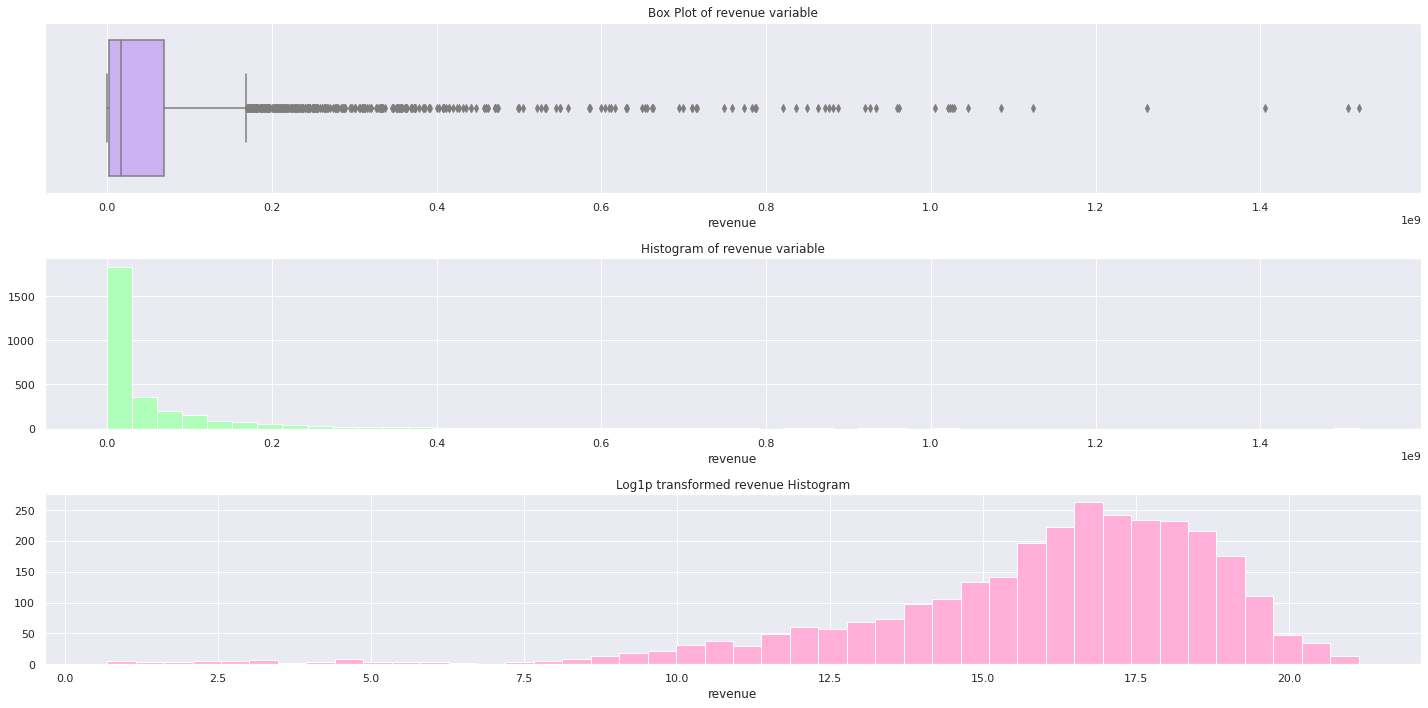

In [83]:
f, ax = plt.subplots(3, figsize=(20,10))

sns.set(rc={'figure.figsize':(12,8)})
sns.boxplot(x=train.revenue, ax = ax[0], color='#caa6fe')
ax[0].set_title("Box Plot of revenue variable")
sns.distplot(a=train.revenue, kde = False, ax = ax[1], color='#afffba', hist_kws=dict(alpha=1))
ax[1].set_title("Histogram of revenue variable")
sns.distplot(a=np.log1p(train.revenue), kde = False, ax = ax[2], color='#ffafd8', hist_kws=dict(alpha=1))
ax[2].set_title("Log1p transformed revenue Histogram")
f.tight_layout()

In [84]:
# 타겟 값의 작은 값 30개 출력
train.revenue.nsmallest(30)

347      1
1754     1
1874     1
1917     1
695      2
334      3
1541     3
2383     3
2117     4
1346     5
2490     6
1190     7
639      8
2251     8
2582     8
280     10
665     10
1141    11
312     12
450     12
2759    13
2399    15
150     18
2090    18
269     20
1884    23
498     25
2032    25
2874    25
1006    30
Name: revenue, dtype: int64

In [85]:
# revenue column에 너무 낮은 이상치들이 존재합니다.

In [86]:
log_features.append("revenue")

In [87]:
#타겟 변수를 보면 수익분포가 오른쪽으로 치우쳐져있습니다. 이는 평균적으로 영화가 6,700만 달러의 수익을 내기 때문입니다.
#Log transform(로그 변환)을 한 후 배포를 하게되면 좀 더 쉽게 관리할 수 있습니다.

가설1. 시리즈물의 여부(해리포터, 트와일라잇 등과 같은)는 수익에 영향을 준다. 

In [88]:
#흥행요소 가운데 시리즈물이냐 아니냐에 따라 흥행의 도움을 줄 수 있기때문에 시리즈물이면 1 아니면 0으로 수정합니다. 

In [89]:
train.belongs_to_collection = train.belongs_to_collection.apply(lambda x: 1 if type(x) == str else 0)
test.belongs_to_collection = test.belongs_to_collection.apply(lambda x: 1 if type(x) == str else 0)

In [90]:
print(train.belongs_to_collection.value_counts()) #대부분의 영화는 독립영화이다.

0    2396
1     604
Name: belongs_to_collection, dtype: int64


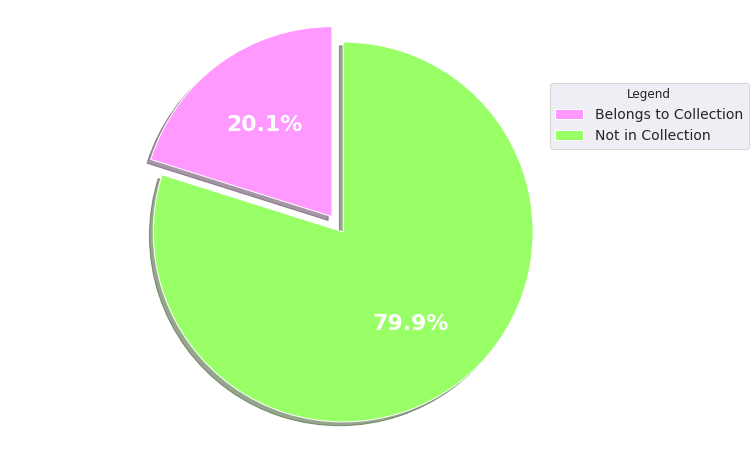

In [91]:
#시각화.
labels = 'Belongs to Collection', 'Not in Collection'
btc_1 = [sum(train.belongs_to_collection), (train.belongs_to_collection == 0).sum(axis=0)]
explode = (0.1, 0)

colors = ['#FF99FF', '#99FF66']

# plot
fig, ax = plt.subplots()
ax.pie(btc_1, explode=explode, autopct='%1.1f%%', shadow=True, startangle=90, colors=colors, textprops={'color':"w", 'fontsize': 22, 'weight':"bold"})
ax.axis('equal') # ensures chart is a circle

ax.legend(labels,
          title="Legend",
          loc="center left",
          fontsize=14,
          bbox_to_anchor=(0.8, 0.25, 0.5, 1))

총 3000개의 데이터중 604개의 영화 (전체의 20.1%)만이 시리즈물이었고 나머지 2396개의 영화는 독립영화였습니다. 시리즈물의 여부는 그 전 시리즈물을 보았을 경우 신작 시리즈물도 시청할 확률이 높기때문에 수익을 예측할 때 좋은 예측데이터가 될 수 있습니다. 

[Text(0, 0, 'Not in Collection'), Text(0, 0, 'Belongs to Collection')]

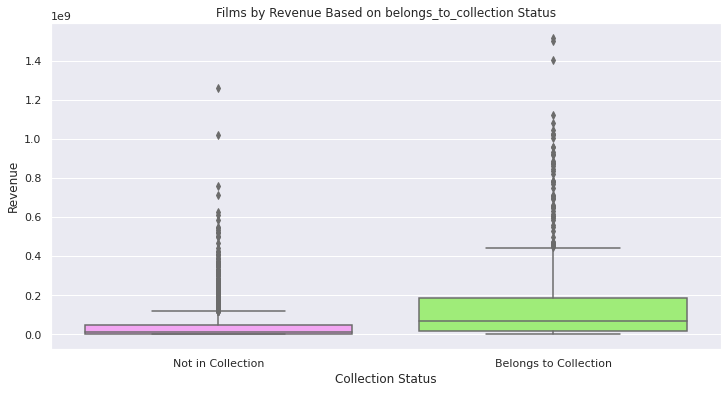

In [92]:
labels = 'Not in Collection', 'Belongs to Collection'

pal1 = ['#FF99FF', '#99FF66']

fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(x='belongs_to_collection', y='revenue', data=train, palette=pal1)
plt.title('Films by Revenue Based on belongs_to_collection Status')
plt.ylabel("Revenue")
plt.xlabel("Collection Status")

ax.set_xticklabels(labels)

그래프를 분석해보면 시리즈물일 경우 수익 높다는 것을 보여줍니다. 이 시각화 자료는 그 전에 세운 가설을 입증하는데 도움이 되는 자료입니다.

In [93]:
train_features.append('belongs_to_collection')

In [94]:
corr, _ = pearsonr(train['belongs_to_collection'], train['revenue'])
print('시리즈물과 수익간의 피어슨상관관계는: %.3f' % corr)
corr, _ = pearsonr(train['belongs_to_collection'], np.log1p(train['revenue']))
print('시리즈물과 로그변환 후 수익간의 피어슨상관관계는: %.3f' % corr)

시리즈물과 수익간의 피어슨상관관계는: 0.339
시리즈물과 로그변환 후 수익간의 피어슨상관관계는: 0.257


In [95]:
#가설검증 결과는 시리즈물은 수익에 좋은 영향을 주지만 많은 양은 아니고 작은 영향을 줍니다. 

가설2. 많은 양의 예산이 투입된 작품의 경우 수익이 좋다.

In [96]:
print('예산colums의 결측치:',train.budget.isna().sum())

예산colums의 결측치: 0


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


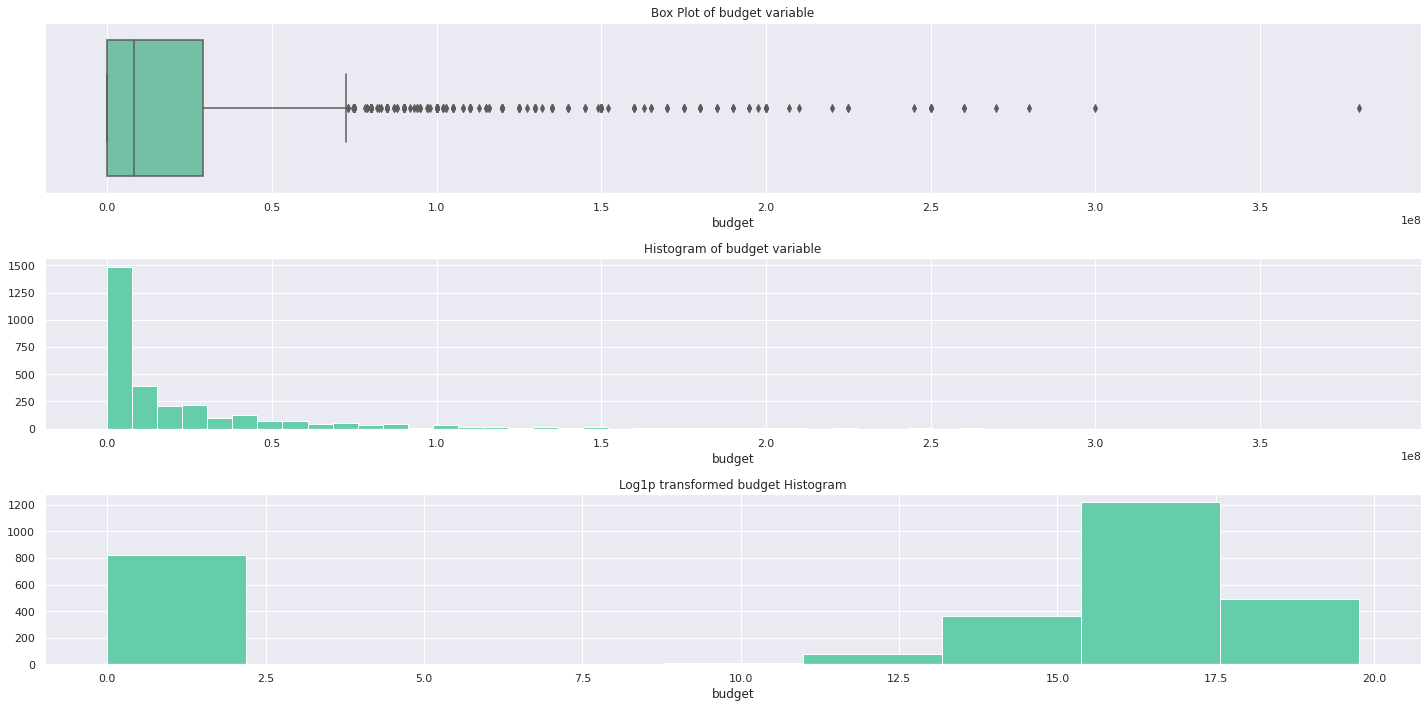

In [97]:
f, ax = plt.subplots(3, figsize=(20,10))

sns.set(rc={'figure.figsize':(12,8)})
sns.boxplot(x=train.budget, ax = ax[0], color='mediumaquamarine')
ax[0].set_title("Box Plot of budget variable")
sns.distplot(a=train.budget, kde = False, ax = ax[1], color='mediumaquamarine', hist_kws=dict(alpha=1))
ax[1].set_title("Histogram of budget variable")
sns.distplot(a=np.log1p(train.budget), kde = False, ax = ax[2], color='mediumaquamarine', hist_kws=dict(alpha=1))
ax[2].set_title("Log1p transformed budget Histogram")
f.tight_layout()

In [98]:
#예산이 0인 영화들이 800개정도 되어보인다.

In [99]:
print('예산이 0인 영화의 개수: ',(train.budget == 0).sum())

예산이 0인 영화의 개수:  812


train dataset의 예산분포가 0을 제외하면 전체적으로 오른쪽으로 치우쳐져 있기때문에 로그 변환분포도 확인했습니다. 
데이터를 살펴보면 예산이 누락된 곳은 없었지만 train data에는 예산이 0인 영화가 812개 있었습니다. 영화를 제작할 때 예산이 0인 경우는 없으므로 예산을 찾을 수 없는 영화를 0으로 대체한듯 보였습니다. 0인 영화 예산을 영화제작하는데 필요한 예산의 평균으로 대체하여 결과물을 도출하려고합니다.

In [100]:
median = train.loc[train['budget'] > 0, 'budget'].median()
train["budget_processed"] = train["budget"].mask(train["budget"] == 0, median)
test["budget_processed"] = test["budget"].mask(test["budget"] == 0, median)

In [101]:
train.nsmallest(30, 'budget_processed')['budget_processed']

334         1.0
695         1.0
849         1.0
1346        1.0
2255        1.0
1754        2.0
2032        4.0
1198        5.0
1800        5.0
639         6.0
796         8.0
2695       10.0
347        12.0
512        93.0
469       113.0
2251      130.0
2117      344.0
1917      592.0
1803     2500.0
2610     5000.0
2855     6000.0
365      7000.0
2781     7300.0
254     11178.0
1893    12000.0
1230    15000.0
2786    17000.0
653     20000.0
259     24554.0
1356    25000.0
Name: budget_processed, dtype: float64

In [102]:
#예산이 0인 영화를 제외하고도 예산이 이상치를 가진 값들이 많이있었습니다. 예산이 10,000불 이하인 영화를 저예산영화로 보고 중심값을 설정하여 결과를 도출합니다. 
median = train.loc[train['budget'] >= 10000, 'budget'].median()
train["budget_processed"] = train["budget"].mask(train["budget"] < 10000, median)
test["budget_processed"] = test["budget"].mask(test["budget"] < 10000, median)

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


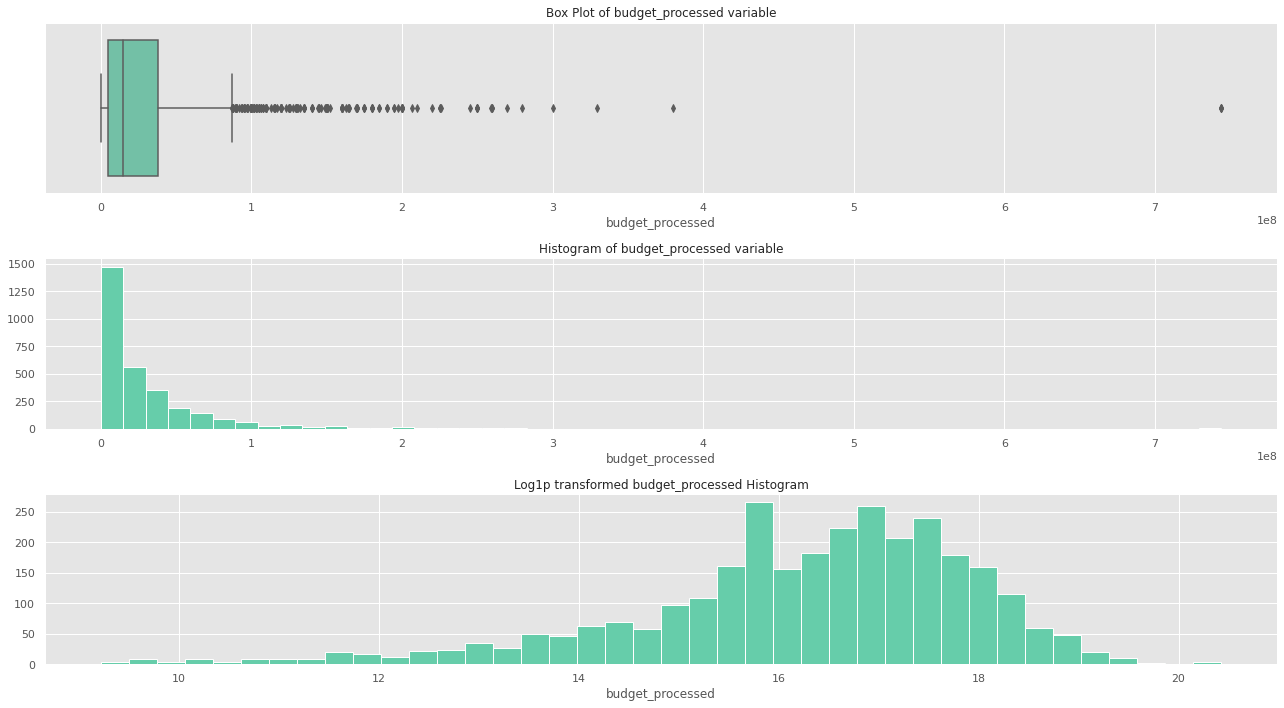

In [360]:
f, ax = plt.subplots(3, figsize=(18,10))

sns.set(rc={'figure.figsize':(12,8)})
sns.boxplot(x=train.budget_processed, ax = ax[0], color='mediumaquamarine')
ax[0].set_title("Box Plot of budget_processed variable")
sns.distplot(a=train.budget_processed, kde = False, ax = ax[1], color='mediumaquamarine', hist_kws=dict(alpha=1))
ax[1].set_title("Histogram of budget_processed variable")
sns.distplot(a=np.log1p(train.budget_processed), kde = False, ax = ax[2], color='mediumaquamarine', hist_kws=dict(alpha=1))
ax[2].set_title("Log1p transformed budget_processed Histogram")
f.tight_layout()

예산이 10000불 이하인 영화가 많이있어 데이터가 좋지않습니다.

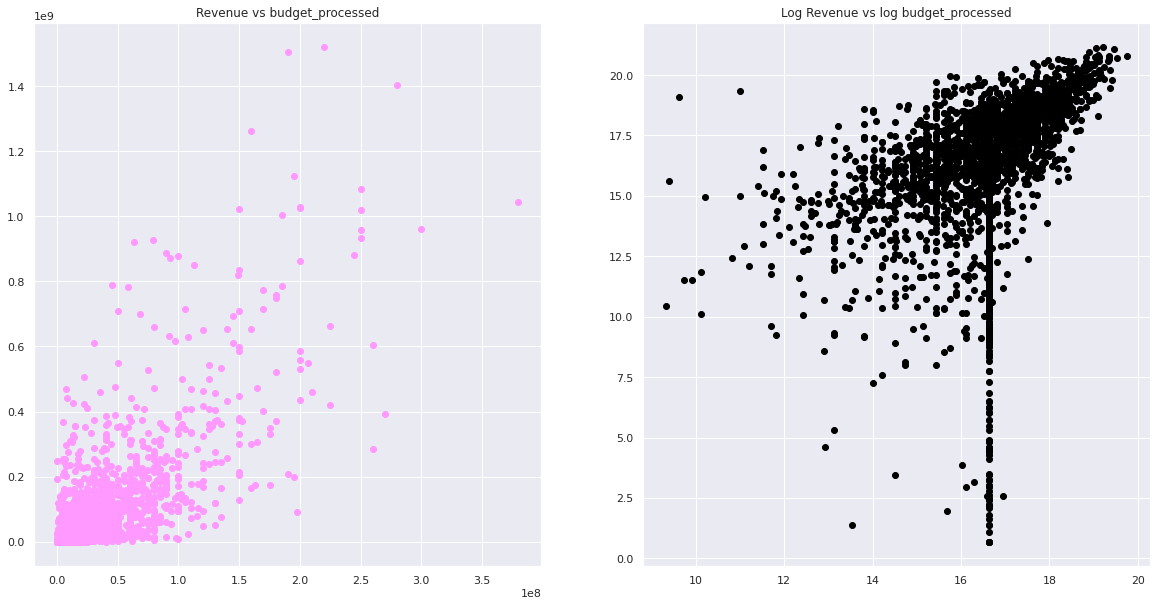

In [104]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.scatter(train['budget_processed'], train['revenue'], color='#FF99FF')
plt.title('Revenue vs budget_processed');
plt.subplot(1, 2, 2)
plt.scatter(np.log1p(train['budget_processed']), np.log1p(train['revenue']), color='black')
plt.title('Log Revenue vs log budget_processed');

In [105]:
log_features.append('budget_processed')

In [106]:
corr, _ = pearsonr(train['budget_processed'], train['revenue'])
print('예산과 수익의 상관관계: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['budget_processed']), np.log1p(train['revenue']))
print('로그변환후 예산과 수익의 상관관계: %.3f' % corr)

예산과 수익의 상관관계: 0.746
로그변환후 예산과 수익의 상관관계: 0.373


예산과 수익의 강한 비례관계를 찾을 수 있었습니다.

In [107]:
#Genres
train['genres'].head()

0                       [{'id': 35, 'name': 'Comedy'}]
1    [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...
2                        [{'id': 18, 'name': 'Drama'}]
3    [{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...
4    [{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...
Name: genres, dtype: object

In [108]:
print("Movies misssing genres: ",train['genres'].isna().sum())

Movies misssing genres:  7


###장르 coolumn의 데이터를 살펴보면 데이터가 너무 더러워 전처리가 필요합니다.


In [109]:
train['genres'] = train['genres'].fillna('')
train['genres_reform'] = train['genres'].apply(lambda x:re.findall("'name': \'(.+?)\'", x))

test['genres'] = test['genres'].fillna('')
test['genres_reform'] = test['genres'].apply(lambda x:re.findall("'name': \'(.+?)\'", x))

In [110]:
#각각의 고유한 열로 이름값지정하고 전제 데이터프레임으로 만들어진다.
def unpackCol(list, df):
    for i in range(len(df)):
        for name in list[i]:
            if name not in df.columns:
                df[name] = 0
            df[name][i] = 1
    return df

In [111]:
df = pd.DataFrame()
df = unpackCol(train['genres_reform'], train)

print(df.columns)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', 'revenue',
       'budget_processed', 'genres_reform', 'Comedy', 'Drama', 'Family',
       'Romance', 'Thriller', 'Action', 'Animation', 'Adventure', 'Horror',
       'Documentary', 'Music', 'Crime', 'Science Fiction', 'Mystery',
       'Foreign', 'Fantasy', 'War', 'Western', 'History', 'TV Movie'],
      dtype='object')


In [112]:
train['num_genres'] = train.genres_reform.apply(lambda x: len(x))
test['num_genres'] = test.genres_reform.apply(lambda x: len(x))

train['num_genres'].value_counts()

2    972
3    900
1    593
4    393
5    111
6     21
0      7
7      3
Name: num_genres, dtype: int64

Text(0.5, 0, 'Genre')

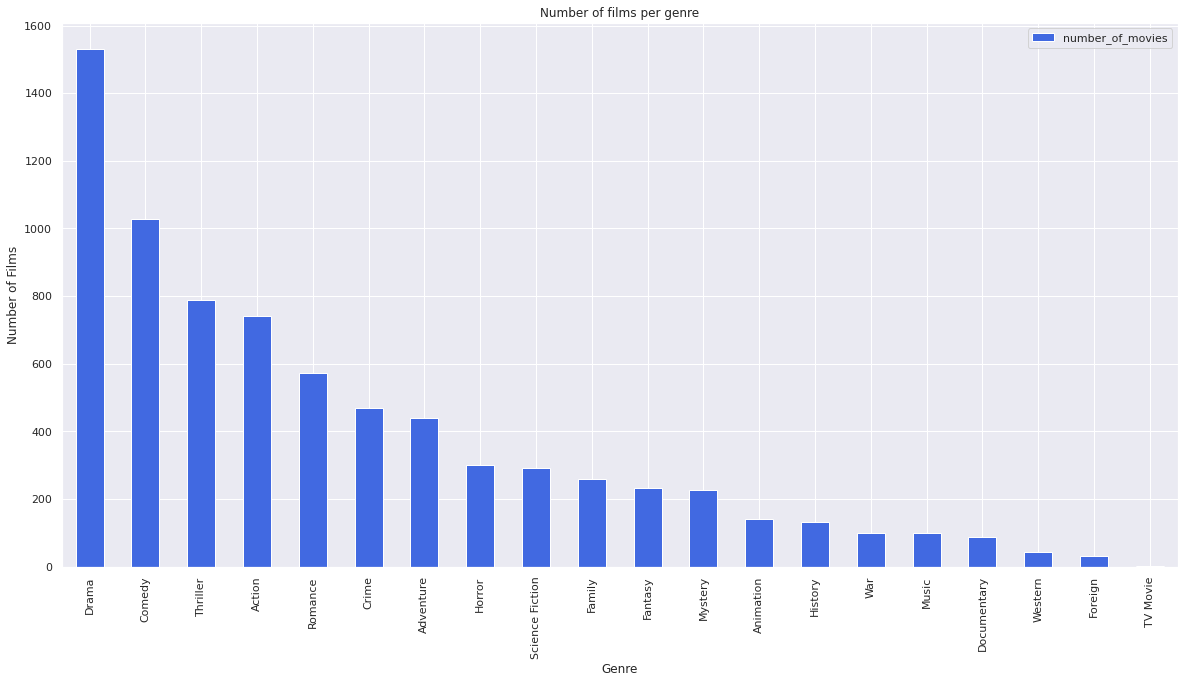

In [113]:
genresDict = dict()

for genre in df["genres_reform"]:
    for elem in genre:
        if elem not in genresDict:
            genresDict[elem] = 1
        else:
            genresDict[elem] += 1


sns.set(rc={'figure.figsize':(20,10)})
genres_df = pd.DataFrame.from_dict(genresDict, orient='index')
genres_df.columns = ["number_of_movies"]
genres_df = genres_df.sort_values(by="number_of_movies", ascending=False)
genres_df.plot.bar(color='royalblue')
plt.title("Number of films per genre")
plt.ylabel("Number of Films")
plt.xlabel("Genre")

In [114]:
##장르에 따라 수익률에 영향을 준다.

In [115]:
genres_df.index.values
for g in genres_df.index.values:
    df[g] = df['genres_reform'].apply(lambda x: 1 if g in x else 0)

# median revenue per genre type
for i, g in enumerate(genres_df.index.values):
    genres_df.loc[g, "median_rev"] = df[df[g]==1].revenue.median()
    
genres_df.sort_values(by=["number_of_movies", "median_rev"], ascending=False).head(10)

# mean revenue for genre type
for i, g in enumerate(genres_df.index.values):
    genres_df.loc[g, "mean_rev"] = df[df[g]==1].revenue.mean()

genres_df.sort_values(by=["number_of_movies", "mean_rev"], ascending=False).head(10)

,number_of_movies,median_rev,mean_rev
Drama,1531,11293663.0,4.540607e+07
Comedy,1028,18809184.0,6.087574e+07
Thriller,789,21890845.0,6.833664e+07
Action,741,36000000.0,1.110434e+08
Romance,571,14016568.0,5.270501e+07
Crime,469,24048000.0,5.949128e+07
Adventure,439,59700000.0,1.758095e+08
Horror,301,17037887.0,5.270907e+07
Science Fiction,290,35109301.5,1.223672e+08
Family,260,57470029.5,1.388978e+08


Text(0.5, 0, 'Genre')

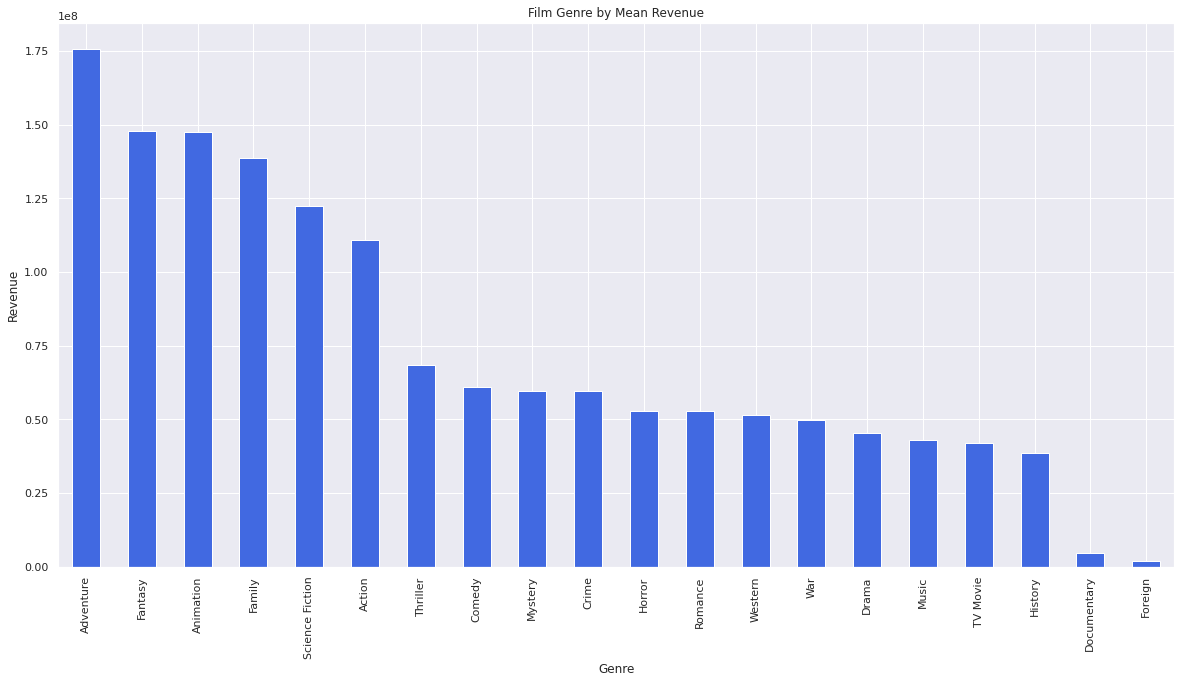

In [116]:
genres_df.sort_values(by=["mean_rev"], ascending=False).mean_rev.plot.bar(color='royalblue')
plt.title("Film Genre by Mean Revenue")
plt.ylabel("Revenue")
plt.xlabel("Genre")

In [117]:
#장르별 평균수익은 어드벤처가 가장높았다.

In [123]:
#장르별 수익률 평균값 시각화

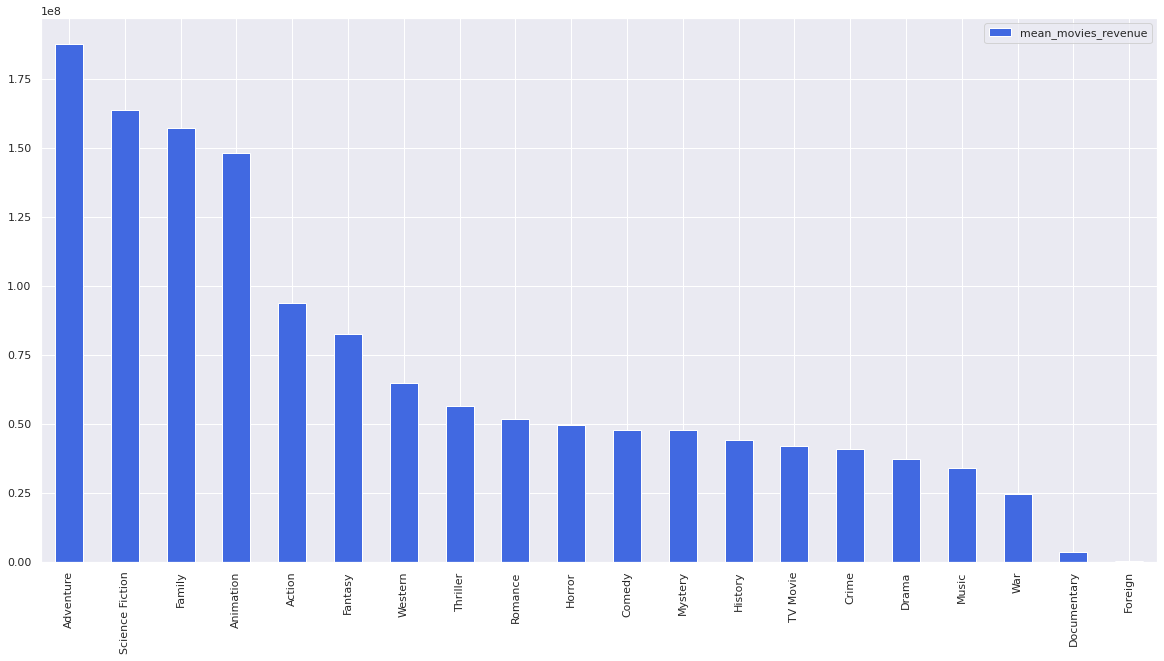

In [122]:
topGenreDict = {}
for element in train[["revenue", "genres_reform"]].values:
   # compare results when looking at top genre
    temp = 1
    if len(element[1]) < temp:
        temp = len(element[1])
    for i in range(temp):
        if element[1][i] not in topGenreDict:
            topGenreDict[element[1][i]] = [element[0], 1]
        else:
            topGenreDict[element[1][i]][0] += element[0]
            topGenreDict[element[1][i]][1] += 1    

for genre in topGenreDict:
    topGenreDict[genre][0] = topGenreDict[genre][0]/topGenreDict[genre][1]
    topGenreDict[genre] = topGenreDict[genre][0]


    
    
genres_df = pd.DataFrame.from_dict(topGenreDict, orient='index', columns=["mean_movies_revenue"])
genres_df.sort_values(by="mean_movies_revenue", ascending=False).head(25).plot.bar(color='royalblue')

In [126]:
#수익률이 높은 장르 정렬
topGenreDict = {k: v for k, v in sorted(topGenreDict.items(), key=lambda item: item[1], reverse = False)}
genresDict = {k: v for k, v in sorted(genresDict.items(), key=lambda item: item[1], reverse = True)}
print(topGenreDict)
print(genresDict)

{'Foreign': 140650.0, 'Documentary': 3538249.971830986, 'War': 24388514.85, 'Music': 33890384.55, 'Drama': 37298750.1133758, 'Crime': 40820052.02040816, 'TV Movie': 42000000.0, 'History': 44237822.875, 'Mystery': 47674838.90909091, 'Comedy': 47754836.36092715, 'Horror': 49586852.62352941, 'Romance': 51648567.82089552, 'Thriller': 56574423.54310345, 'Western': 64905713.538461536, 'Fantasy': 82345105.41176471, 'Action': 93596599.80576923, 'Animation': 148089684.90789473, 'Family': 157347482.6111111, 'Science Fiction': 163833801.36585367, 'Adventure': 187715537.32085562}
{'Drama': 1531, 'Comedy': 1028, 'Thriller': 789, 'Action': 741, 'Romance': 571, 'Crime': 469, 'Adventure': 439, 'Horror': 301, 'Science Fiction': 290, 'Family': 260, 'Fantasy': 232, 'Mystery': 225, 'Animation': 141, 'History': 132, 'Music': 100, 'War': 100, 'Documentary': 87, 'Western': 43, 'Foreign': 31, 'TV Movie': 1}


In [127]:
def getGenreRank(genres):
    sum = 0
    for g in genres:
        sum += list(topGenreDict.keys()).index(g)
    return (sum / len(genres))

In [128]:

train['genre_rank'] = train['genres_reform'].apply(lambda x: getGenreRank(x) if len(x) > 0 else 0)
test['genre_rank'] = test['genres_reform'].apply(lambda x: getGenreRank(x) if len(x) > 0 else 0)

train['genre_rank'].value_counts()

9.000000     273
4.000000     270
8.000000     229
10.000000    216
7.500000     132
            ... 
11.142857      1
14.600000      1
16.600000      1
12.200000      1
10.800000      1
Name: genre_rank, Length: 132, dtype: int64

#### 장르를 순위로 나타냄 따로 뽑아냄(수익별)

In [129]:
log_features.append('genre_rank')
log_features.append('num_genres')

In [131]:
corr, _ = pearsonr(train['genre_rank'], train['revenue'])
print('장르순위와 수익간 상관관계: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['genre_rank']), np.log1p(train['revenue']))
print('로그변환 후 장르순위와 수익간 상관관계 : %.3f' % corr)

장르순위와 수익간 상관관계: 0.324
로그변환 후 장르순위와 수익간 상관관계 : 0.303


In [133]:
corr, _ = pearsonr(train['num_genres'], train['revenue'])
print('장르와 수익상관관계: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['num_genres']), np.log1p(train['revenue']))
print('로그변환 후 장르와 수익상관관계: %.3f' % corr)

장르와 수익상관관계: 0.164
로그변환 후 장르와 수익상관관계: 0.191


In [134]:
## 장르 순위와 수익사이 상관관계가 장르와 수익간의 상관관계 수치보다 높다. 즉, train데이터로는 장르순위가 더 적합하다.

In [137]:
#Movies missing a homepage데이터는 2054개
print('Movies missing a homepage:',train.homepage.isna().sum())

Movies missing a homepage: 2054


In [138]:
#홈페이지 데이터를 사용하기엔 효율이 좋지않아 홈페이지 여부만을 판별하는 새로운 열을 만듭니다.

In [139]:
train['has_homepage'] = train.homepage.apply(lambda x: 0 if pd.isnull(x) else 1)
test['has_homepage'] = test.homepage.apply(lambda x: 0 if pd.isnull(x) else 1)
train['has_homepage'].value_counts()

0    2054
1     946
Name: has_homepage, dtype: int64

In [ ]:
#2054개의 영화는 홈페이지가 없고, 946개의 영화만 홈페이지가 있다.

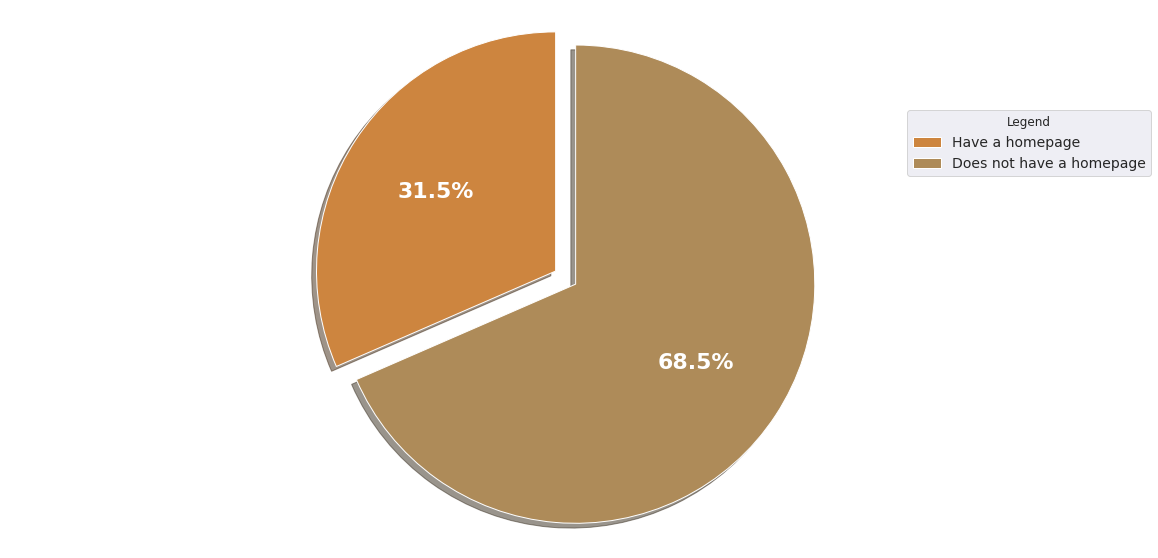

In [144]:
#시각화
labels = 'Have a homepage', 'Does not have a homepage'
btc_1 = [sum(train.has_homepage), (train.has_homepage == 0).sum(axis=0)]
explode = (0.1, 0)

colors = ['#CD853F', '#AE8B59']

fig, ax = plt.subplots()
ax.pie(btc_1, explode=explode, autopct='%1.1f%%', shadow=True, startangle=90, colors=colors, textprops={'color':"w", 'fontsize': 22, 'weight':"bold"})
ax.axis('equal')

ax.legend(labels,
          title="Legend",
          loc="center left",
          fontsize=14,
          bbox_to_anchor=(0.8, 0.25, 0.5, 1))

plt.show()

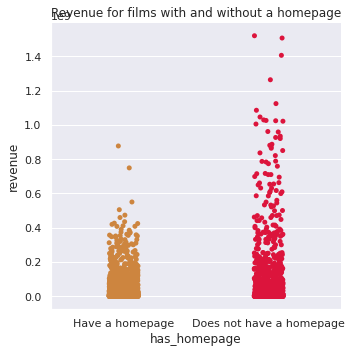

In [148]:
pal1 = ['#CD853F', 'crimson']

ax = sns.catplot(x='has_homepage', y='revenue', data=train, palette=pal1);
plt.title('Revenue for films with and without a homepage');

labels = 'Have a homepage', 'Does not have a homepage'
ax.set_xticklabels(labels)

In [149]:
train_features.append('has_homepage')

In [151]:
corr, _ = pearsonr(train['has_homepage'], train['revenue'])
print('홈페이지 여부와 수익간의 상관계수: %.3f' % corr)
corr, _ = pearsonr(train['has_homepage'], np.log1p(train['revenue']))
print('로그변환 후 홈페이지 여부와 수익간의 상관계수: %.3f' % corr)

홈페이지 여부와 수익간의 상관계수: 0.263
로그변환 후 홈페이지 여부와 수익간의 상관계수: 0.143


In [ ]:
#홈페이지 존재유무는 수익의 관계가 있지만 범주형 그래프를 보면 홈페이지가 없는 영화가 더 높은 수익을 기록하는 것을 볼 수 있습니다.


In [152]:
cols_to_drop.append("imdb_id")

In [153]:
#English or other languges data
print("Counts of each original language:")
print(train['original_language'].value_counts()[:10])

Counts of each original language:
en    2575
fr      78
ru      47
es      43
hi      42
ja      37
it      24
ko      20
cn      20
zh      19
Name: original_language, dtype: int64


Text(0.5, 1.0, 'Revenue for a movie and its and original_language')

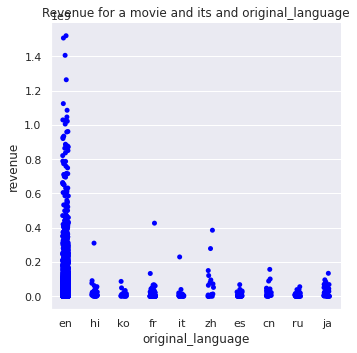

In [155]:
sns.catplot(x='original_language', y='revenue', color='blue', data=train.loc[train['original_language'].isin(train['original_language'].value_counts().head(10).index)])
plt.title('Revenue for a movie and its and original_language')

In [156]:
#대부분의 영화가 영어로 제작되었으면 영어로 제작된 영화의 수익이 훨씬 큰 것을 확인할 수 있습니다. 데이터를 영어나 아니냐로 나누어 확인해보곘습니다.

In [157]:
train['originally_english'] = train.original_language.apply(lambda x: 1 if x == 'en' else 0)
test['originally_english'] = test.original_language.apply(lambda x: 1 if x == 'en' else 0)
train['originally_english'].value_counts()

1    2575
0     425
Name: originally_english, dtype: int64

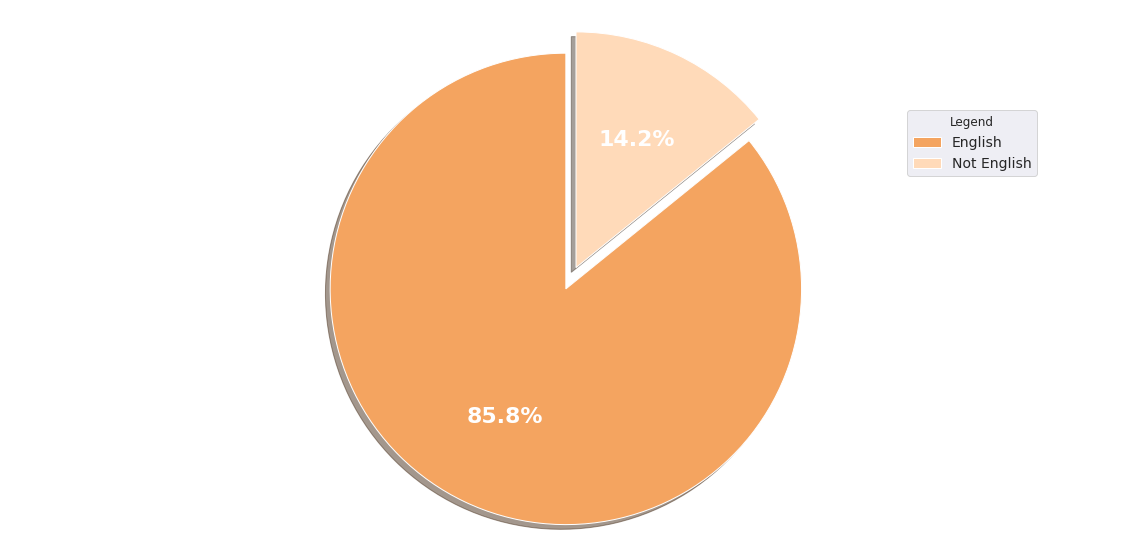

In [159]:
labels = 'English', 'Not English'
btc_1 = [(train.originally_english == 1).sum(axis=0), (train.originally_english == 0).sum(axis=0)]
explode = (0.1, 0)

colors = ['sandybrown', 'peachpuff']

fig, ax = plt.subplots()
ax.pie(btc_1, explode=explode, autopct='%1.1f%%', shadow=True, startangle=90, colors=colors, textprops={'color':"w", 'fontsize': 22, 'weight':"bold"})
ax.axis('equal') # ensures chart is a circle

ax.legend(labels,
          title="Legend",
          loc="center left",
          fontsize=14,
          bbox_to_anchor=(0.8, 0.25, 0.5, 1))

plt.show()


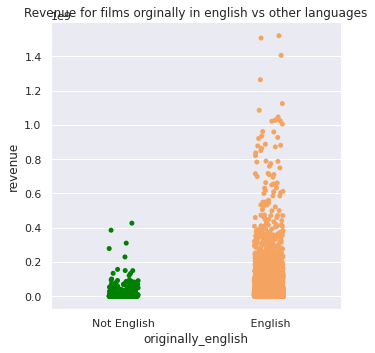

In [163]:
pal2 = ['green', 'sandybrown']

ax = sns.catplot(x='originally_english', y='revenue', data=train, palette=pal2);
plt.title('Revenue for films orginally in english vs other languages');

labels = 'Not English', ' English'
ax.set_xticklabels(labels)

In [164]:
train_features.append('originally_english')

In [165]:
corr, _ = pearsonr(train['originally_english'], train['revenue'])
print('영화의 언어와 수익의 상관계수: %.3f' % corr)

영화의 언어와 수익의 상관계수: 0.142


In [167]:
#데이터를 양의 상관계수라고 판단하기엔 비 영어의 영화가 너무 작다.

In [169]:
#필요없는데이터 제거
cols_to_drop.append('original_title')
cols_to_drop.append('overview')
cols_to_drop.append('popularity')
cols_to_drop.append('poster_path')

In [172]:
#영화 제작사에 따라 수익률 변화가 있다.
train['production_companies'].head(20)

0     [{'name': 'Paramount Pictures', 'id': 4}, {'na...
1           [{'name': 'Walt Disney Pictures', 'id': 2}]
2     [{'name': 'Bold Films', 'id': 2266}, {'name': ...
3                                                   NaN
4                                                   NaN
5                                                   NaN
6     [{'name': 'Ghost House Pictures', 'id': 768}, ...
7                                                   NaN
8     [{'name': 'Walt Disney Pictures', 'id': 2}, {'...
9     [{'name': 'Castle Rock Entertainment', 'id': 97}]
10               [{'name': 'United Artists', 'id': 60}]
11    [{'name': 'Twentieth Century Fox Film Corporat...
12    [{'name': 'DreamWorks SKG', 'id': 27}, {'name'...
13    [{'name': 'Double Feature Films', 'id': 215}, ...
14    [{'name': 'DreamWorks SKG', 'id': 27}, {'name'...
15                [{'name': 'Hypnopolis', 'id': 51316}]
16    [{'name': 'DreamWorks SKG', 'id': 27}, {'name'...
17    [{'name': 'BBC Films', 'id': 288}, {'name'

In [173]:
#회사명의 데이터가 더러워 원하는 결과를 도출할 수 없기때문에 전처리가 필요하다.

In [174]:
train['production_companies'].isna()

0       False
1       False
2       False
3        True
4        True
        ...  
2995    False
2996    False
2997    False
2998    False
2999    False
Name: production_companies, Length: 3000, dtype: bool

In [175]:
train['production_companies'] = train['production_companies'].fillna('')
train['production_companies_reform'] = train['production_companies'].apply(lambda x:re.findall("'name': \'(.+?)\'", x))

test['production_companies'] = test['production_companies'].fillna('')
test['production_companies_reform'] = test['production_companies'].apply(lambda x:re.findall("'name': \'(.+?)\'", x))

df['production_companies'] = df['production_companies'].fillna('')
df['production_companies_reform'] = df['production_companies'].apply(lambda x:re.findall("'name': \'(.+?)\'", x))

In [176]:
train['num_studios'] = train.production_companies_reform.apply(lambda x: len(x))
test['num_studios'] = test.production_companies_reform.apply(lambda x: len(x))
df['num_studios'] = train.production_companies_reform.apply(lambda x: len(x))

train['num_studios'].value_counts()

1     781
2     734
3     582
4     308
5     166
0     157
6     116
7      69
8      36
9      27
10      8
11      6
15      3
12      3
14      2
13      1
16      1
Name: num_studios, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


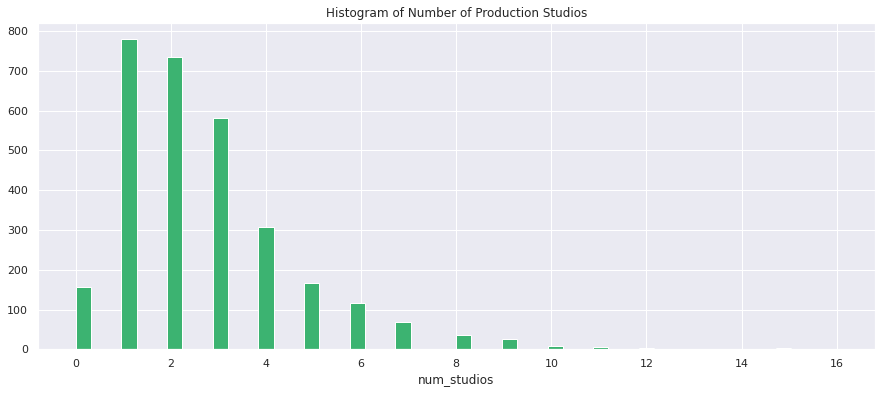

In [178]:
sns.distplot(train['num_studios'], kde=False, color='mediumseagreen', hist_kws=dict(alpha=1))
sns.set(rc={'figure.figsize':(20,10)})
plt.title('Histogram of Number of Production Studios')
plt.show();

In [179]:
#시각화 자료를 보면 대부분의 영화는 1~4번째 영화사에의해 제작된다. 하지만 이것으로는 원하는 데이터의 결과를 도출해낼수 없다.

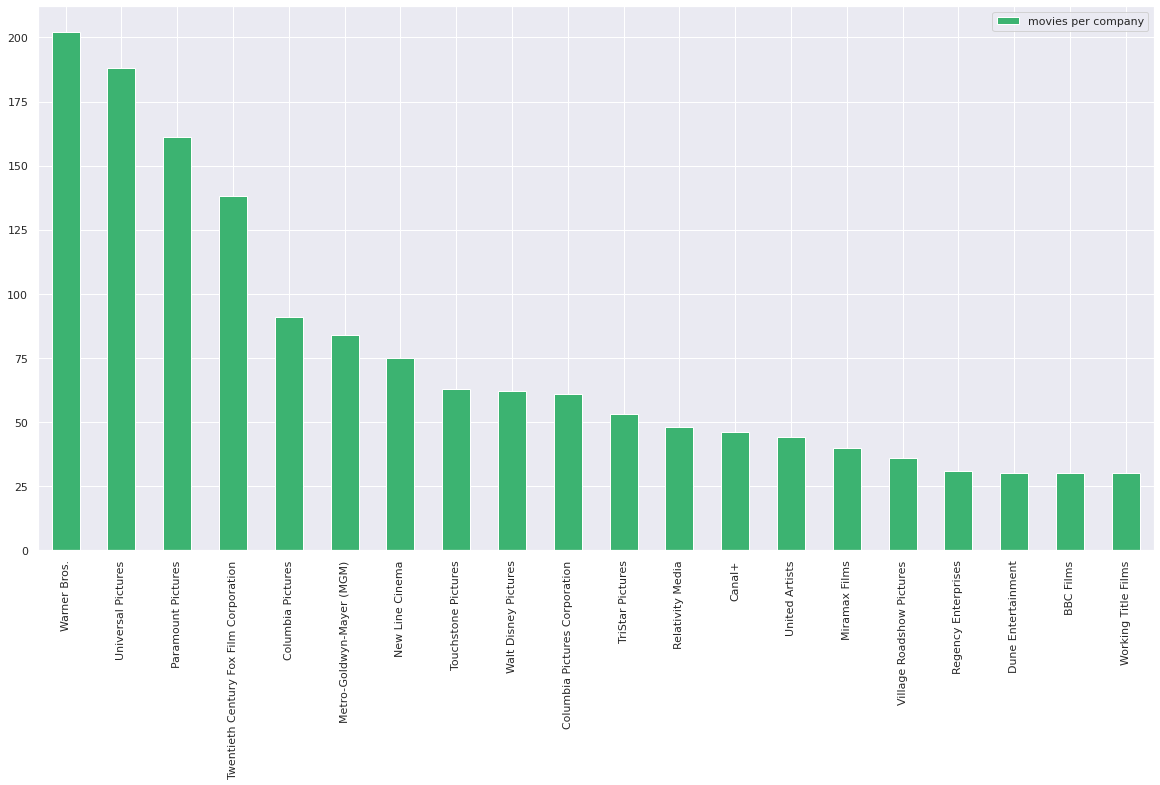

In [181]:
#영화 제작사별 제작영화의 수를 살펴보자.
companiesDict = {}
for element in train["production_companies_reform"].values:
    for company in element:
        if company not in companiesDict:
            companiesDict[company] = 1
        else:
            companiesDict[company] += 1

companies_train = pd.DataFrame.from_dict(companiesDict, orient='index', columns=["movies per company"])
companies_train.sort_values(by="movies per company", ascending=False).head(20).plot.bar(color='mediumseagreen')

companies_train.columns = ["number_of_studios"]

In [183]:
companiesDict2 = {}
for element in df["production_companies_reform"].values:
    for company in element:
        if company not in companiesDict2:
            companiesDict2[company] = 1
        else:
            companiesDict2[company] += 1

companies_df = pd.DataFrame.from_dict(companiesDict2, orient='index', columns=["movies per company"])

companies_df.columns = ["number_of_studios"]

companies_df.index.values
for g in companies_df.index.values:
    df[g] = df['production_companies_reform'].apply(lambda x: 1 if g in x else 0)

# 제작사별 중간수익값
for i, g in enumerate(companies_df.index.values):
    companies_df.loc[g, "median_rev"] = df[df[g]==1].revenue.median()
    
companies_df.sort_values(by=["number_of_studios", "median_rev"], ascending=False).head(10)

# 제작사별 평균수익값
for i, g in enumerate(companies_df.index.values):
    companies_df.loc[g, "mean_rev"] = df[df[g]==1].revenue.mean()

companies_df.sort_values(by=["number_of_studios", "mean_rev"], ascending=False).head(10)

# 제작사별 총 수익
for i, g in enumerate(companies_df.index.values):
    companies_df.loc[g, "sum_rev"] = df[df[g]==1].revenue.sum()

companies_df.sort_values(by=["number_of_studios", "sum_rev"], ascending=False).head(10)

,number_of_studios,median_rev,mean_rev,sum_rev
Warner Bros.,202,55653705.5,1.203347e+08,2.430760e+10
Universal Pictures,188,59540581.5,1.096708e+08,2.061812e+10
Paramount Pictures,161,52034889.0,1.247831e+08,2.009007e+10
Twentieth Century Fox Film Corporation,138,50589532.0,1.139619e+08,1.572674e+10
Columbia Pictures,91,77737889.0,1.202844e+08,1.094588e+10
Metro-Goldwyn-Mayer (MGM),84,13220811.0,6.872146e+07,5.772602e+09
New Line Cinema,75,60740827.0,1.451592e+08,1.088694e+10
Touchstone Pictures,63,34808403.0,7.654655e+07,4.822432e+09
Walt Disney Pictures,62,160440216.0,3.037771e+08,1.883418e+10
Columbia Pictures Corporation,61,58853106.0,7.591135e+07,4.630592e+09


Text(0.5, 0, 'Production Studio')

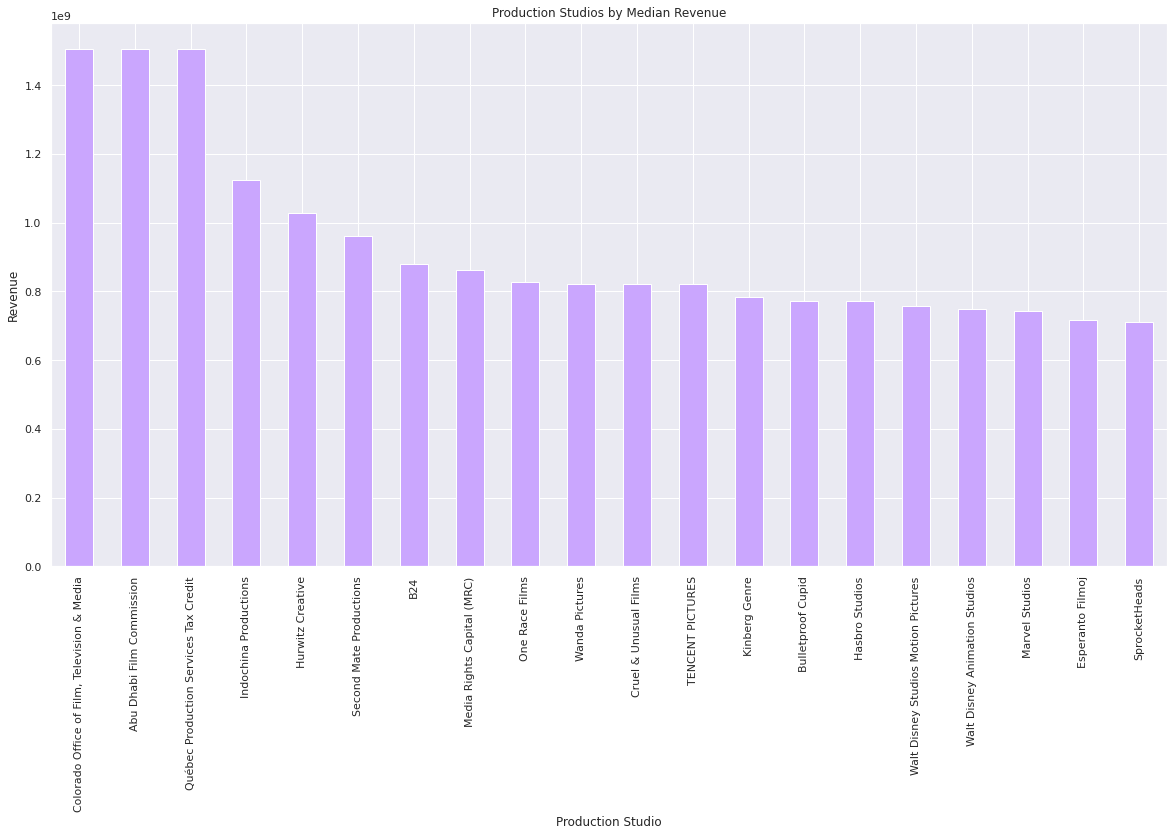

In [187]:
# 회사별 중간 수익값
companies_df.sort_values(by=["median_rev"], ascending=False).median_rev.head(20).plot.bar(color='#caa6fe')
plt.title("Production Studios by Median Revenue")
plt.ylabel("Revenue")
plt.xlabel("Production Studio")

Text(0.5, 0, 'Production Studio')

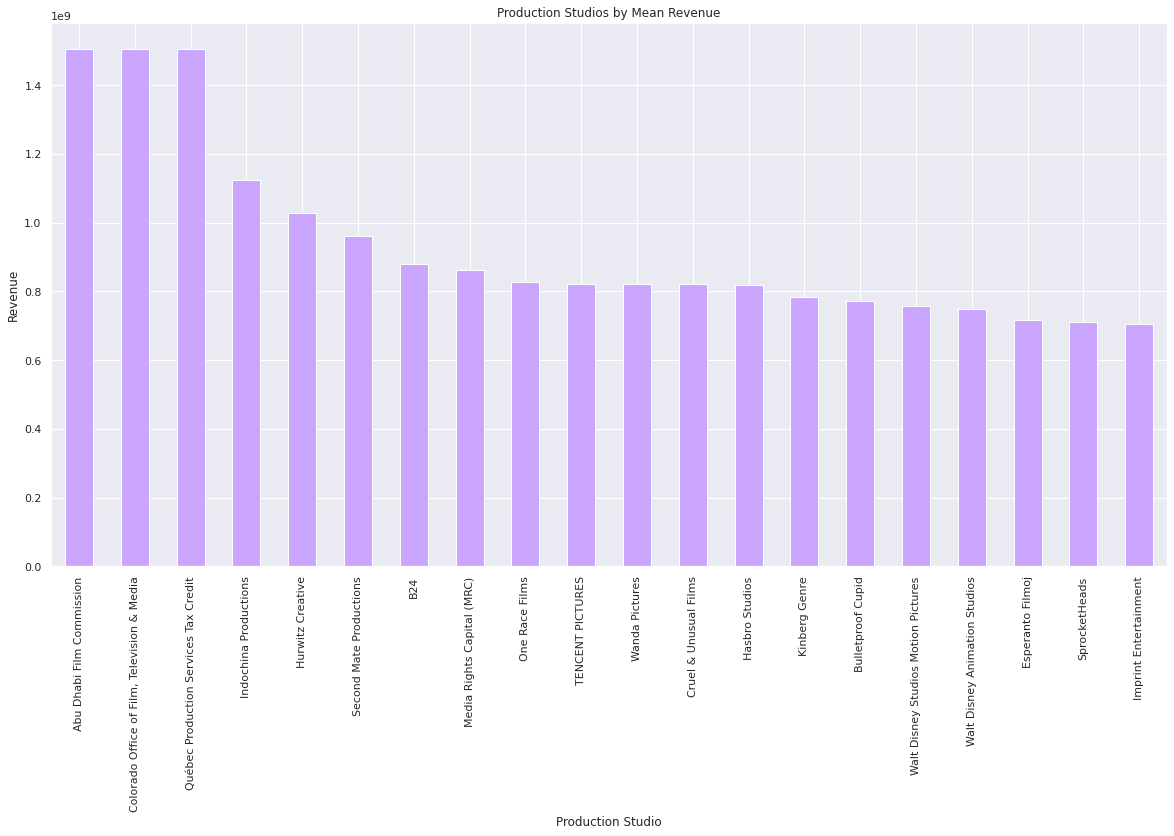

In [186]:
# 회사별 평균 수익값
companies_df.sort_values(by=["mean_rev"], ascending=False).mean_rev.head(20).plot.bar(color='#caa6fe')
plt.title("Production Studios by Mean Revenue")
plt.ylabel("Revenue")
plt.xlabel("Production Studio")

Text(0.5, 0, 'Production Studio')

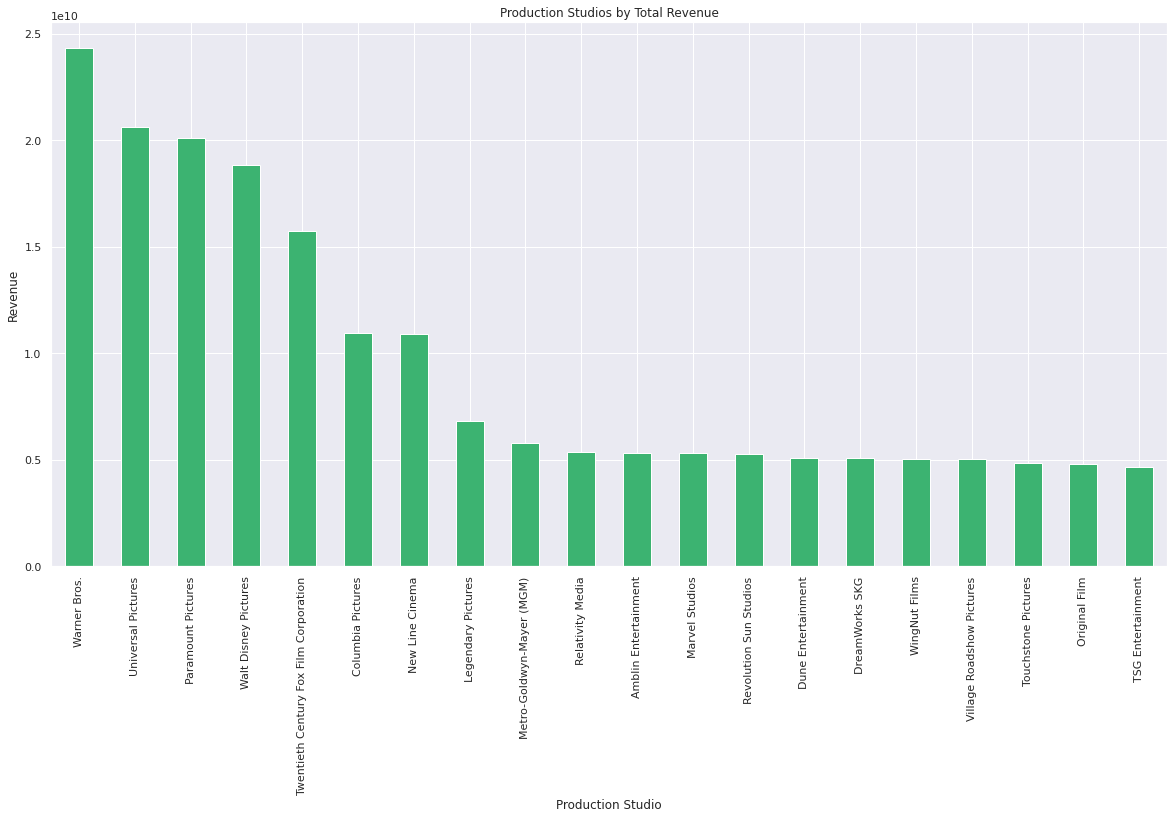

In [188]:
# 회사별 총 수익값
companies_df.sort_values(by=["sum_rev"], ascending=False).sum_rev.head(20).plot.bar(color='mediumseagreen')
plt.title("Production Studios by Total Revenue")
plt.ylabel("Revenue")
plt.xlabel("Production Studio")

Text(0.5, 0, 'Production Studio')

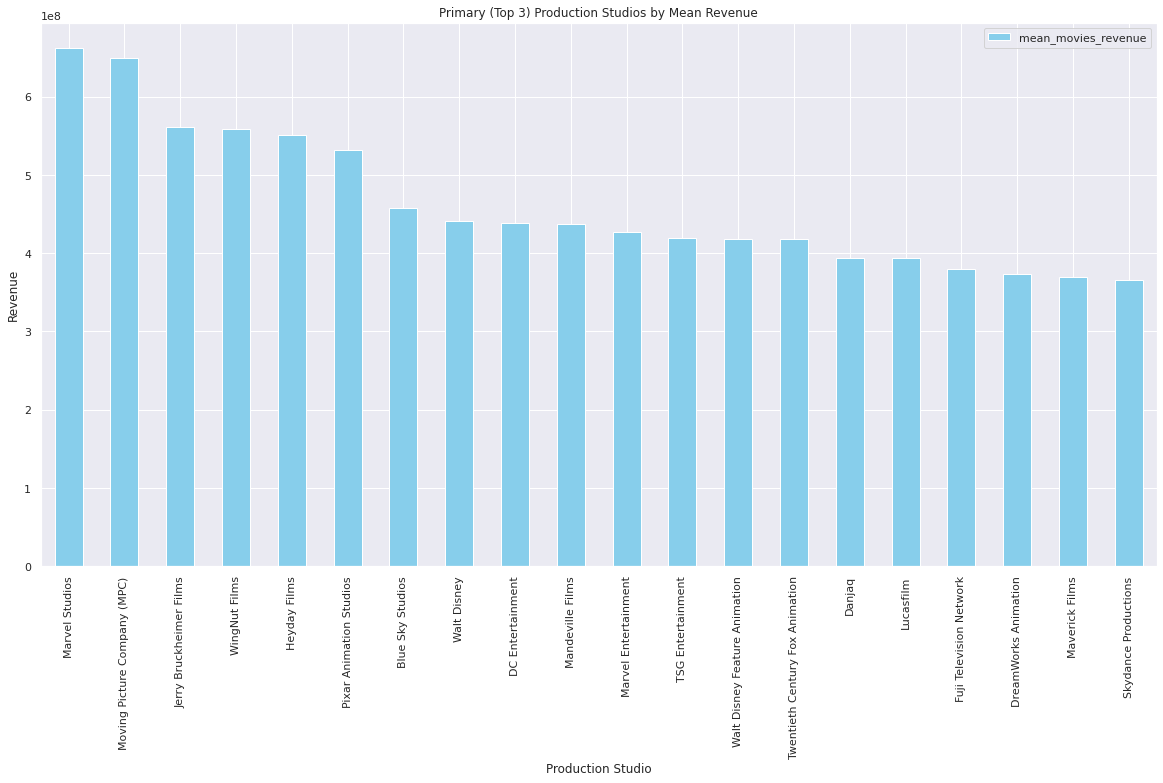

In [191]:

studiosDict = {}
for element in train[["revenue", "production_companies_reform"]].values:
    temp = 3
    if len(element[1]) < temp:
        temp = len(element[1])
    for i in range(temp):
        if element[1][i] not in studiosDict:
            studiosDict[element[1][i]] = [element[0], 1]
        else:
            studiosDict[element[1][i]][0] += element[0]
            studiosDict[element[1][i]][1] += 1    

studiosDict = {k: v for k, v in studiosDict.items() if v[1] >= 3}

for company in studiosDict:
    studiosDict[company][0] = studiosDict[company][0]/studiosDict[company][1]
    studiosDict[company] = studiosDict[company][0]


    
    
studios_train = pd.DataFrame.from_dict(studiosDict, orient='index', columns=["mean_movies_revenue"])
studios_train.sort_values(by="mean_movies_revenue", ascending=False).head(20).plot.bar(color='skyblue')
plt.title("Primary (Top 3) Production Studios by Mean Revenue")
plt.ylabel("Revenue")
plt.xlabel("Production Studio")

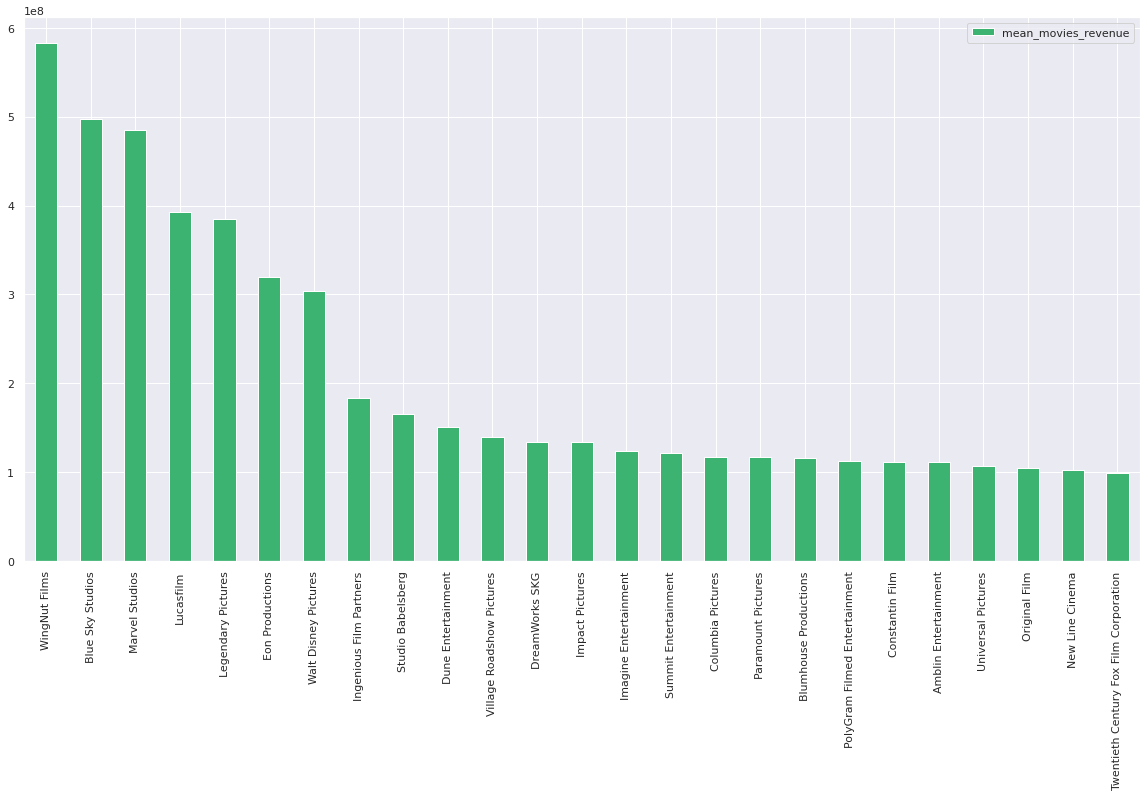

In [190]:
#상위 스튜디오를 시각화 하여 결과비교
topStudiosDict = {}
for element in train[["revenue", "production_companies_reform"]].values:
    temp = 1
    if len(element[1]) < temp:
        temp = len(element[1])
    for i in range(temp):
        if element[1][i] not in topStudiosDict:
            topStudiosDict[element[1][i]] = [element[0], 1]
        else:
            topStudiosDict[element[1][i]][0] += element[0]
            topStudiosDict[element[1][i]][1] += 1    

topStudiosDict = {k: v for k, v in topStudiosDict.items() if v[1] >= 5}

for company in topStudiosDict:
    topStudiosDict[company][0] = topStudiosDict[company][0]/topStudiosDict[company][1]
    topStudiosDict[company] = topStudiosDict[company][0]


    
    
studios_df = pd.DataFrame.from_dict(topStudiosDict, orient='index', columns=["mean_movies_revenue"])
studios_df.sort_values(by="mean_movies_revenue", ascending=False).head(25).plot.bar(color='mediumseagreen')

In [192]:
topStudiosDict = {k: v for k, v in sorted(topStudiosDict.items(), key=lambda item: item[1], reverse = True)}
studiosDict = {k: v for k, v in sorted(studiosDict.items(), key=lambda item: item[1], reverse = True)}


def checkTopStudios(studio):
    if len(studio) < 1 or studio[0] not in list(topStudiosDict)[:50]:
        return 0
    else:
        return 1

def checkStudios(studio):
    if len(studio) < 1:
        return 0
    count = 0
    for company in studio[:10]:
        if company in list(studiosDict)[:100]:
            count += 1
    return count

def getStudioRanks(studios):
    if len(studios) < 1:
        return 400
    rank = 0
    for s in studios[:5]:
        if s in list(studiosDict):
            rank += list(studiosDict.keys()).index(s)
    if rank == 0:
        rank = 400
    return rank / len(studios)

#상위 스튜디오에 대한 새로운 열 추가
train['topStudio'] = train['production_companies_reform'].apply(lambda x: checkTopStudios(x))
test['topStudio'] = test['production_companies_reform'].apply(lambda x: checkTopStudios(x))
train['numTopStudios'] = train['production_companies_reform'].apply(lambda x: checkStudios(x))
test['numTopStudios'] = test['production_companies_reform'].apply(lambda x: checkStudios(x))

studiosDict = {k: v for k, v in sorted(studiosDict.items(), key=lambda item: item[1], reverse = True)}

train['studioRank'] = train['production_companies_reform'].apply(lambda x: getStudioRanks(x))
test['studioRank'] = test['production_companies_reform'].apply(lambda x: getStudioRanks(x))

print(train['topStudio'].value_counts())
print()
print(train['numTopStudios'].value_counts())
print()
print(train['studioRank'].value_counts())

0    1682
1    1318
Name: topStudio, dtype: int64

0    2187
1     597
2     158
3      52
4       4
5       2
Name: numTopStudios, dtype: int64

400.000000    470
200.000000    154
133.333333    104
91.000000      52
109.000000     40
             ... 
13.250000       1
49.500000       1
292.000000      1
229.000000      1
32.714286       1
Name: studioRank, Length: 986, dtype: int64


In [193]:
len(studiosDict)

399

In [195]:
#상관계수 분석
corr, _ = pearsonr(train['topStudio'], train['revenue'])
print('topStudio and revenue: %.3f' % corr)
corr, _ = pearsonr(train['topStudio'], np.log1p(train['revenue']))
print('topStudio and revenue: %.3f' % corr)
print()

# analysis of correlation and create log feature
corr, _ = pearsonr(train['numTopStudios'], train['revenue'])
print('numTopStudios and revenue: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['numTopStudios']), np.log1p(train['revenue']))
print('numTopStudios and revenue: %.3f' % corr)
print()

# analysis of correlation and create log feature
corr, _ = pearsonr(train['studioRank'], train['revenue'])
print('studioRank and revenue: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['studioRank']), np.log1p(train['revenue']))
print('studioRank and revenue: %.3f' % corr)
print()

# analysis of correlation and create log feature
corr, _ = pearsonr(train['num_studios'], train['revenue'])
print('num_studios and revenue: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['num_studios']), np.log1p(train['revenue']))
print('num_studios and revenue: %.3f' % corr)

topStudio and revenue: 0.320
topStudio and revenue: 0.436

numTopStudios and revenue: 0.558
numTopStudios and revenue: 0.419

studioRank and revenue: -0.309
studioRank and revenue: -0.412

num_studios and revenue: 0.154
num_studios and revenue: 0.269


In [196]:
train_features.append('topStudio')
log_features.append('numTopStudios')
log_features.append('num_studios')
log_features.append('studioRank')

In [ ]:
#제작국가에 따른 수익변화

In [197]:
print('결측치:',train.production_countries.isna().sum())

결측치: 55


In [198]:
train.production_countries = train.production_countries.fillna("")
train['production_countries_processed'] = train['production_countries'].apply(lambda x: re.findall("'name': \'(.+?)\'", x))

train['num_production_countries'] = train['production_countries_processed'].apply(lambda x: len(x))

test.production_countries = test.production_countries.fillna("")
test['production_countries_processed'] = test['production_countries'].apply(lambda x: re.findall("'name': \'(.+?)\'", x))

test['num_production_countries'] = test['production_countries_processed'].apply(lambda x: len(x))

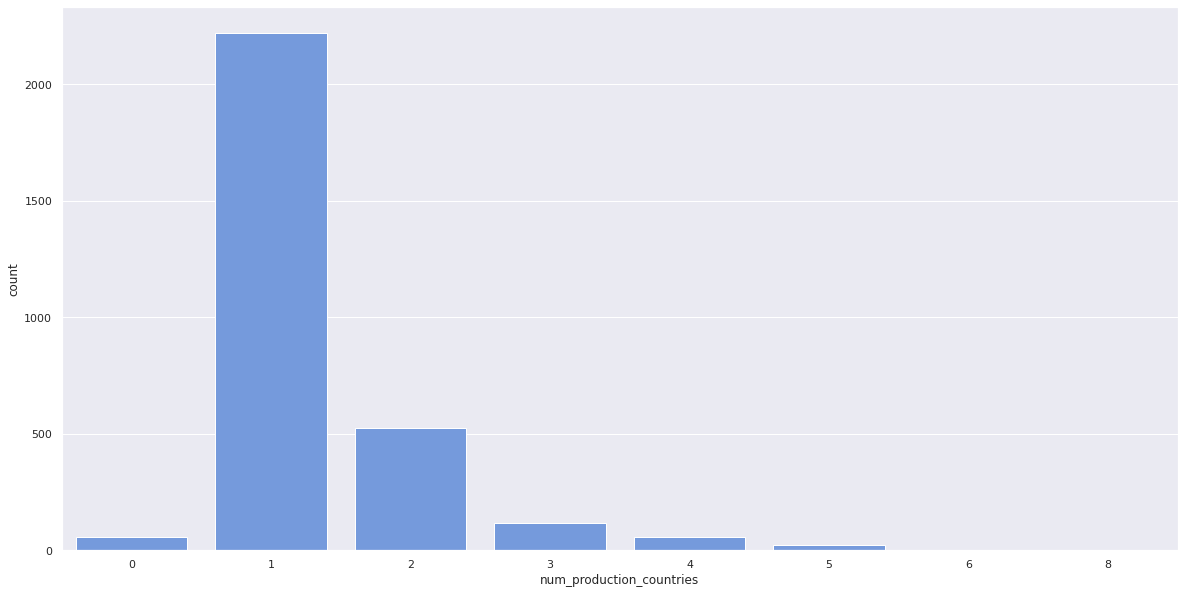

In [199]:
sns.set(rc={'figure.figsize':(20,10)})
sns.countplot(x=train.num_production_countries, color='cornflowerblue')

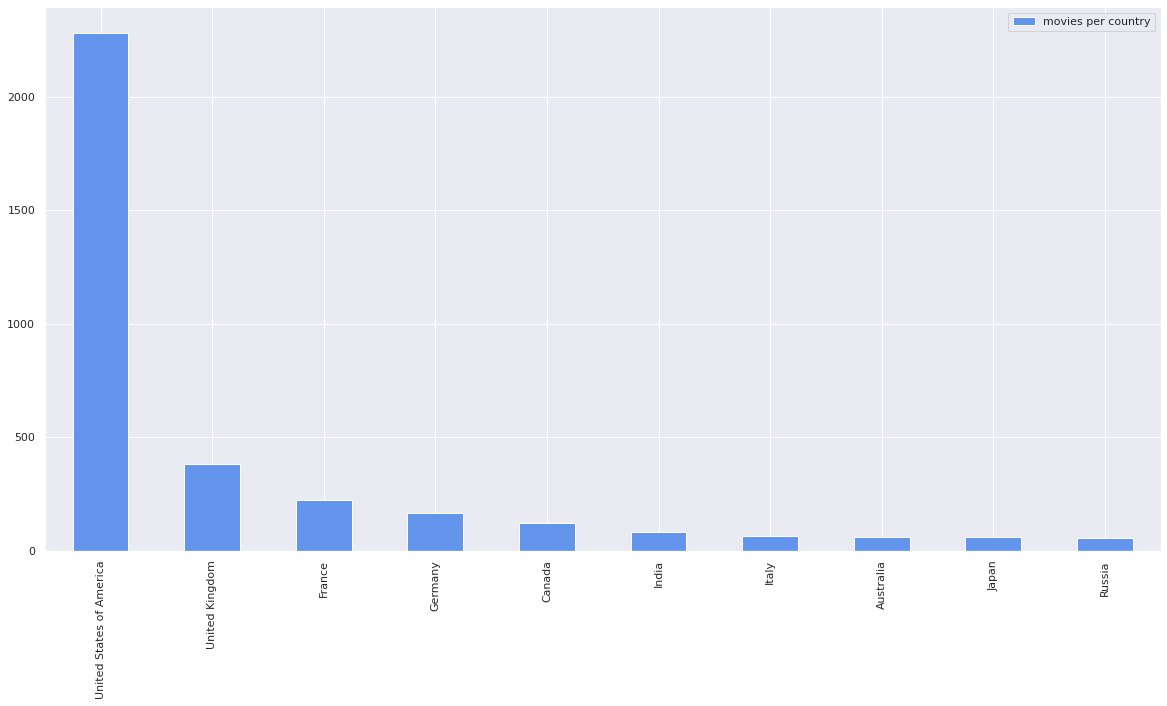

In [200]:
countriesDict = {}
for element in train["production_countries_processed"].values:
    for country in element:
        if country not in countriesDict:
            countriesDict[country] = 1
        else:
            countriesDict[country] += 1

countries_train = pd.DataFrame.from_dict(countriesDict, orient='index', columns=["movies per country"])
countries_train.sort_values(by="movies per country", ascending=False).head(10).plot.bar(color='cornflowerblue')

In [201]:
#제작국가가 미국이냐 아니냐로 판별
train['usa_produced'] = train.production_countries_processed.apply(lambda x: 1 if 'United States of America' in x else 0)
test['usa_produced'] = test.production_countries_processed.apply(lambda x: 1 if 'United States of America' in x else 0)
train['usa_produced'].value_counts()

1    2282
0     718
Name: usa_produced, dtype: int64

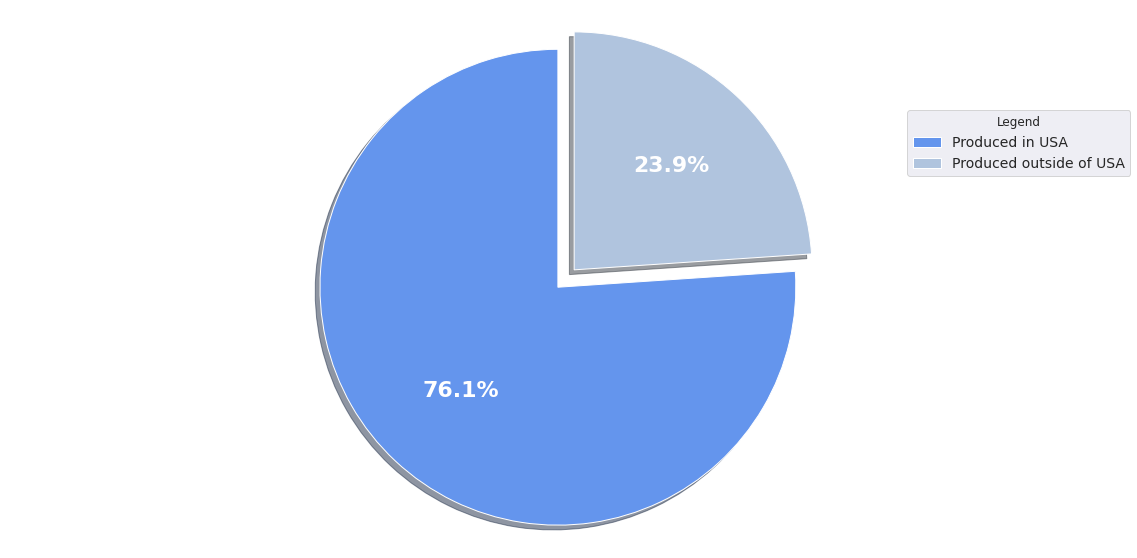

In [202]:
labels = 'Produced in USA', 'Produced outside of USA'
btc_1 = [sum(train.usa_produced), (train.usa_produced == 0).sum(axis=0)]
explode = (0.1, 0)

colors = ['cornflowerblue', 'lightsteelblue']

fig, ax = plt.subplots()
ax.pie(btc_1, explode=explode, autopct='%1.1f%%', shadow=True, startangle=90, colors=colors, textprops={'color':"w", 'fontsize': 22, 'weight':"bold"})
ax.axis('equal') # ensures chart is a circle

ax.legend(labels,
          title="Legend",
          loc="center left",
          fontsize=14,
          bbox_to_anchor=(0.8, 0.25, 0.5, 1))

plt.show()

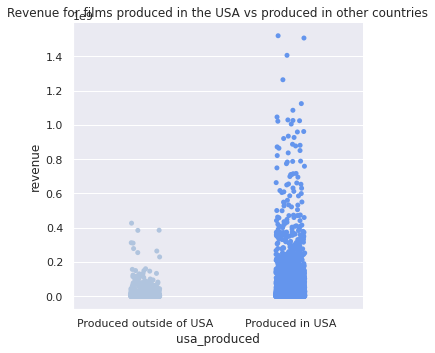

In [204]:
pal3 = ['lightsteelblue', 'cornflowerblue']

ax = sns.catplot(x='usa_produced', y='revenue', data=train, palette=pal3);
plt.title('Revenue for films produced in the USA vs produced in other countries');

labels = 'Produced outside of USA', 'Produced in USA'
ax.set_xticklabels(labels)

In [205]:
#상관관계
corr, _ = pearsonr(train['usa_produced'], train['revenue'])
print('usa_produced and revenue: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['usa_produced']), np.log1p(train['revenue']))
print('log transformed usa_produced and log transformed revenue: %.3f' % corr)

usa_produced and revenue: 0.198
log transformed usa_produced and log transformed revenue: 0.300


In [206]:
#로직변환후 상관관계가 작은 수는 아니기 때문에 train data에 넣어준다.
log_features.append('num_production_countries')
train_features.append('usa_produced')

In [207]:
#출시일을 기준으로 수익과의 관계를 알아본다.
train['release_date'].head(10)

0     2/20/15
1      8/6/04
2    10/10/14
3      3/9/12
4      2/5/09
5      8/6/87
6     8/30/12
7     1/15/04
8     2/16/96
9     4/16/03
Name: release_date, dtype: object

In [208]:
#data는 표준 일/월/년도 순으로 출력되지만 더 좋은 결과값을 위해 데이터를 일월년 따로 출력할수 있게 전처리를해줍니다.
train_date = train['release_date']

train_date = pd.to_datetime(train_date)
train_date.dt
print(train_date)

0      2015-02-20
1      2004-08-06
2      2014-10-10
3      2012-03-09
4      2009-02-05
          ...    
2995   1994-04-22
2996   2013-03-28
2997   1996-10-11
2998   2004-01-16
2999   2011-09-22
Name: release_date, Length: 3000, dtype: datetime64[ns]


In [209]:
print(train_date.dt.year)
print(train_date.dt.dayofweek)
print(train_date.dt.dayofyear)
print(train_date.dt.weekofyear)

0       2015
1       2004
2       2014
3       2012
4       2009
        ... 
2995    1994
2996    2013
2997    1996
2998    2004
2999    2011
Name: release_date, Length: 3000, dtype: int64
0       4
1       4
2       4
3       4
4       3
       ..
2995    4
2996    3
2997    4
2998    4
2999    3
Name: release_date, Length: 3000, dtype: int64
0        51
1       219
2       283
3        69
4        36
       ... 
2995    112
2996     87
2997    285
2998     16
2999    265
Name: release_date, Length: 3000, dtype: int64
0        8
1       32
2       41
3       10
4        6
        ..
2995    16
2996    13
2997    41
2998     3
2999    38
Name: release_date, Length: 3000, dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  after removing the cwd from sys.path.


In [211]:
print(train.release_date.describe())


count        3000
unique       2398
top       9/10/10
freq            5
Name: release_date, dtype: object


In [212]:
print(train_date.dt.year.describe())

count    3000.000000
mean     2005.046333
std        15.919610
min      1971.000000
25%      1995.000000
50%      2006.000000
75%      2012.000000
max      2070.000000
Name: release_date, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Year of Release Date by Number of Films')

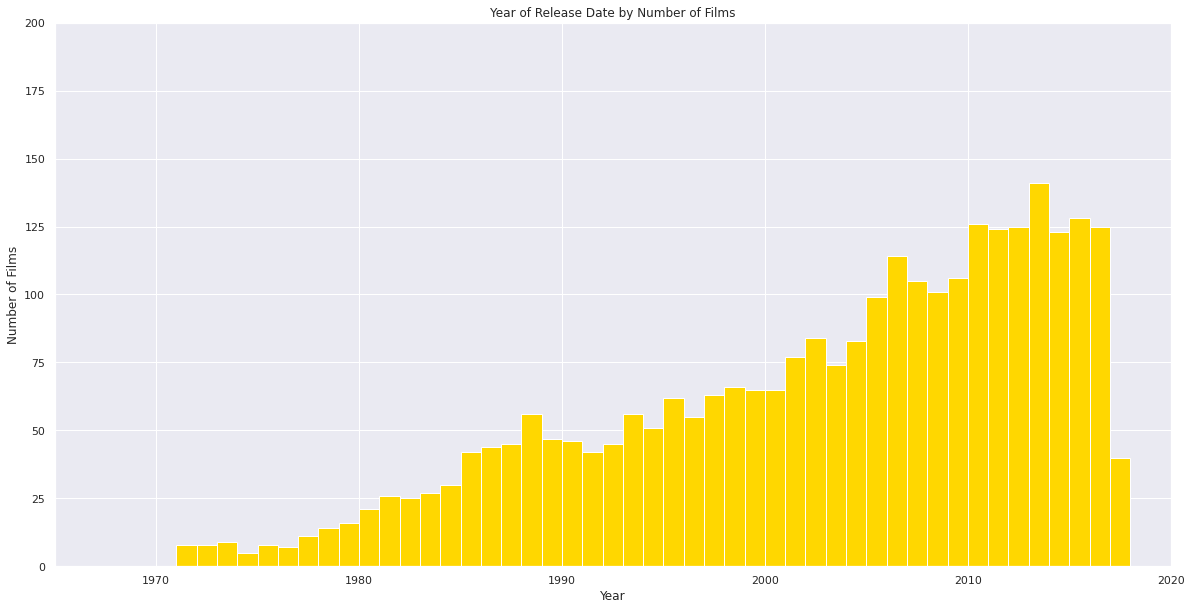

In [215]:
#년도별 영화분포도

fig, dx = plt.subplots()
sns.distplot(train_date.dt.year, bins=99, kde=False, color='gold', hist_kws=dict(alpha=1))
sns.set(rc={'figure.figsize':(20, 10)})

dx.set(xlim=(1965, 2020),ylim=(0,200))
dx.set_xlabel("Year")
dx.set_ylabel("Number of Films")
dx.set_title("Year of Release Date by Number of Films")

In [ ]:
#시간이 지남에 따라 출시영화가 증가합니다. 이는 전체적인 영화 산업의 규모가 커지고있다는 것을 의미합니다.


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0, 0, ''),
 Text(0, 0, 'Monday'),
 Text(0, 0, 'Tuesday'),
 Text(0, 0, 'Wednesday'),
 Text(0, 0, 'Thursday'),
 Text(0, 0, 'Friday'),
 Text(0, 0, 'Saturday'),
 Text(0, 0, 'Sunday'),
 Text(0, 0, '')]

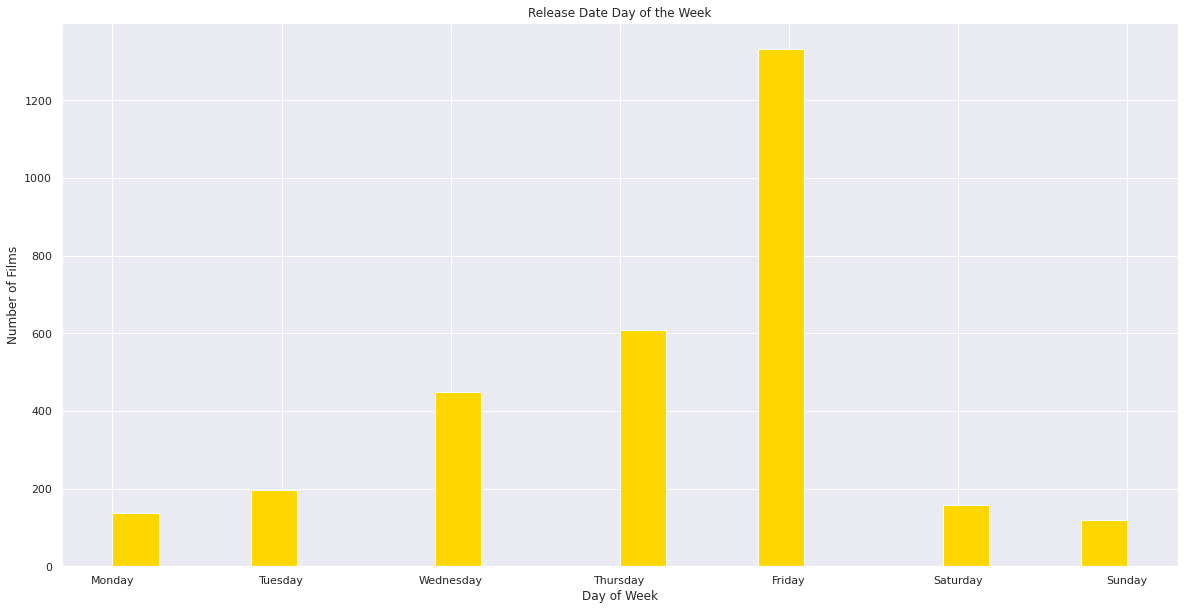

In [218]:
#요일별 영화

fig, ex = plt.subplots()
sns.distplot(train_date.dt.dayofweek, kde=False, color='gold', hist_kws=dict(alpha=1))
sns.set(rc={'figure.figsize':(20,10)})

ex.set_xlabel("Day of Week")
ex.set_ylabel("Number of Films")
ex.set_title("Release Date Day of the Week")

labels = [item.get_text() for item in ex.get_xticklabels()]
labels[1] = 'Monday'
labels[2] = 'Tuesday'
labels[3] = 'Wednesday'
labels[4] = 'Thursday'
labels[5] = 'Friday'
labels[6] = 'Saturday'
labels[7] = 'Sunday'

ex.set_xticklabels(labels)

In [219]:
#영화 출시일이 금요일날 유독 많이 출시되는데 이것은 주말 전 기대수익이 가장크기때문이라고 판단할 수 있습니다.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Release Date Day of the Year')

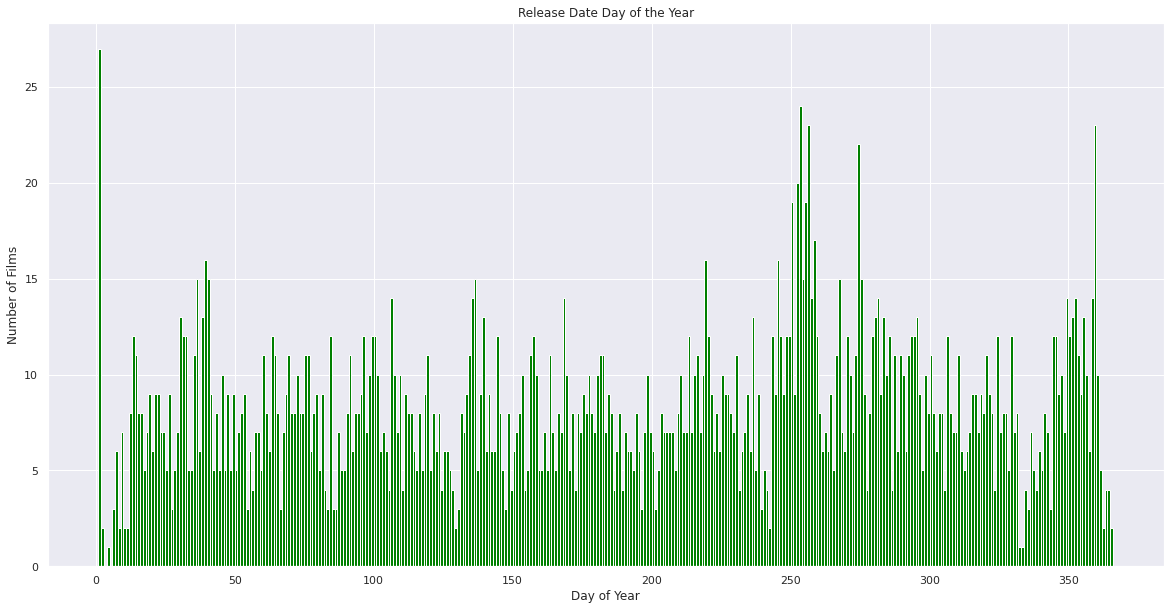

In [222]:
fig, fx = plt.subplots()
sns.distplot(train_date.dt.dayofyear, bins=365, kde=False, color='Green', hist_kws=dict(alpha=1))
sns.set(rc={'figure.figsize':(20,10)})

fx.set_xlabel("Day of Year")
fx.set_ylabel("Number of Films")
fx.set_title("Release Date Day of the Year")

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Release Date Month of the Year')

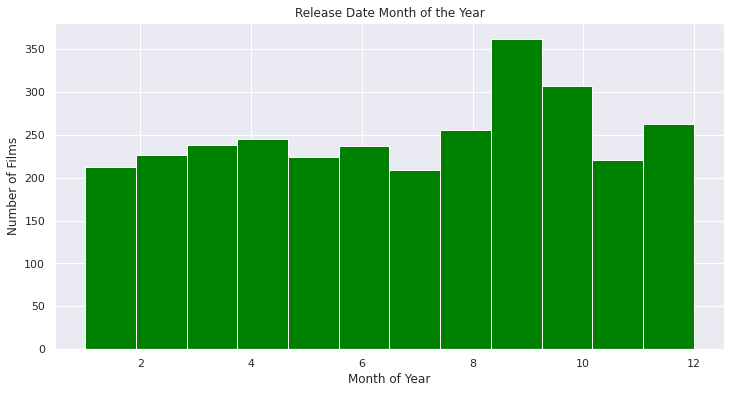

In [225]:
fig, hx = plt.subplots()
sns.distplot(train_date.dt.month, bins=12, kde=False, color='Green', hist_kws=dict(alpha=1))
sns.set(rc={'figure.figsize':(20,10)})

hx.set_xlabel("Month of Year")
hx.set_ylabel("Number of Films")
hx.set_title("Release Date Month of the Year")

In [226]:
#월간별로 보면 8~9월 영화가 상대적으로 많이 개봉하는데 이것은 8~9월 기대수익이 가장 크다고 예상할 수 있습니다. 

[Text(0, 0, '1971'),
 Text(0, 0, '1972'),
 Text(0, 0, '1973'),
 Text(0, 0, '1974'),
 Text(0, 0, '1975'),
 Text(0, 0, '1976'),
 Text(0, 0, '1977'),
 Text(0, 0, '1978'),
 Text(0, 0, '1979'),
 Text(0, 0, '1980'),
 Text(0, 0, '1981'),
 Text(0, 0, '1982'),
 Text(0, 0, '1983'),
 Text(0, 0, '1984'),
 Text(0, 0, '1985'),
 Text(0, 0, '1986'),
 Text(0, 0, '1987'),
 Text(0, 0, '1988'),
 Text(0, 0, '1989'),
 Text(0, 0, '1990'),
 Text(0, 0, '1991'),
 Text(0, 0, '1992'),
 Text(0, 0, '1993'),
 Text(0, 0, '1994'),
 Text(0, 0, '1995'),
 Text(0, 0, '1996'),
 Text(0, 0, '1997'),
 Text(0, 0, '1998'),
 Text(0, 0, '1999'),
 Text(0, 0, '2000'),
 Text(0, 0, '2001'),
 Text(0, 0, '2002'),
 Text(0, 0, '2003'),
 Text(0, 0, '2004'),
 Text(0, 0, '2005'),
 Text(0, 0, '2006'),
 Text(0, 0, '2007'),
 Text(0, 0, '2008'),
 Text(0, 0, '2009'),
 Text(0, 0, '2010'),
 Text(0, 0, '2011'),
 Text(0, 0, '2012'),
 Text(0, 0, '2013'),
 Text(0, 0, '2014'),
 Text(0, 0, '2015'),
 Text(0, 0, '2016'),
 Text(0, 0, '2017'),
 Text(0, 0, '

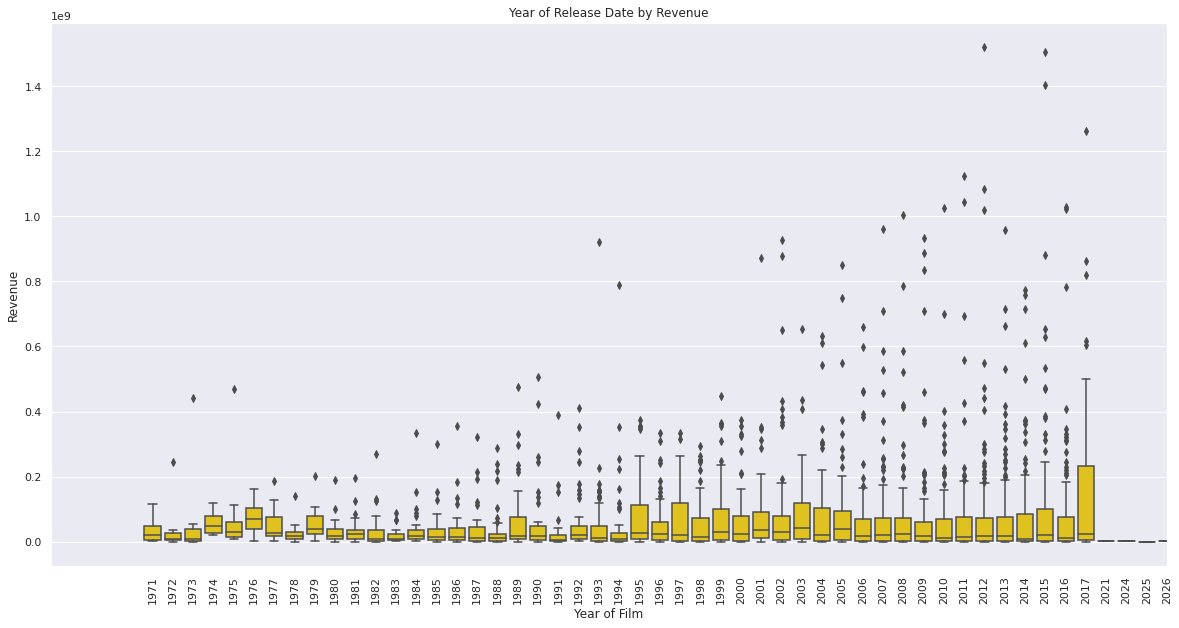

In [227]:
fig, dx = plt.subplots()
sns.boxplot(x=train_date.dt.year, y=train['revenue'], color='gold')
sns.set(rc={'figure.figsize':(12, 6)})

dx.set(xlim=(-5, 50))
dx.set_xlabel("Year of Film")
dx.set_ylabel("Revenue")
dx.set_title("Year of Release Date by Revenue")

dx.set_xticklabels(dx.get_xticklabels(), rotation=90)

In [228]:
#시대별로 보면 영화의 수익은 해마다 증가하고 있고 중간중간 특정 년도에 수익이 눈에띄게 올라가는 이유는 어떤 영화가 대히트를 칠 경우입니다.

[Text(0, 0, 'Monday'),
 Text(0, 0, 'Tuesday'),
 Text(0, 0, 'Wednesday'),
 Text(0, 0, 'Thursday'),
 Text(0, 0, 'Friday'),
 Text(0, 0, 'Saturday'),
 Text(0, 0, 'Sunday')]

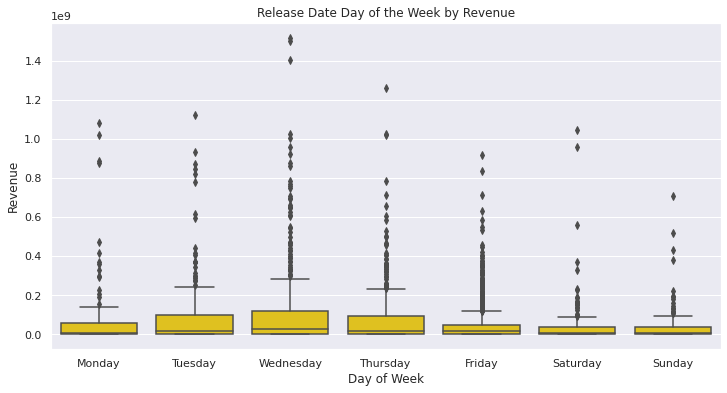

In [229]:
fig, ex = plt.subplots()
sns.boxplot(x=train_date.dt.dayofweek, y=train['revenue'], color='gold')
sns.set(rc={'figure.figsize':(12, 6)})

ex.set_xlabel("Day of Week")
ex.set_ylabel("Revenue")
ex.set_title("Release Date Day of the Week by Revenue")

labels = [item.get_text() for item in ex.get_xticklabels()]
labels[0] = 'Monday'
labels[1] = 'Tuesday'
labels[2] = 'Wednesday'
labels[3] = 'Thursday'
labels[4] = 'Friday'
labels[5] = 'Saturday'
labels[6] = 'Sunday'

ex.set_xticklabels(labels)

In [230]:
#아까와 같이 요일별로 분석한 결과 수익은 수요일날 가장 높은것을 알 수있었는데 예상과는 달라 모델에 좋은 효과를 줄 것입니다.

In [231]:
train["release_date"] = train["release_date"].fillna(train["release_date"].mode()[0])
test["release_date"] = test["release_date"].fillna(train["release_date"].mode()[0])

train['temp'] = train.release_date.apply(lambda x: datetime.strptime(x, '%m/%d/%y'))
test['temp'] = test.release_date.apply(lambda x: datetime.strptime(x, '%m/%d/%y'))

train["month"] = train.temp.apply(lambda x: x.month)
test["month"] = test.temp.apply(lambda x: x.month)

train["year"] = train.temp.apply(lambda x: x.year)
test["year"] = test.temp.apply(lambda x: x.year)

train["day_of_week"] = train.temp.apply(lambda x: x.weekday()+1)
test["day_of_week"] = test.temp.apply(lambda x: x.weekday()+1)

train["week_of_year"] = train.temp.apply(lambda x: x.isocalendar()[1])
test["week_of_year"] = test.temp.apply(lambda x: x.isocalendar()[1])


train = train.drop(['temp'], axis=1)
test = test.drop(['temp'], axis=1)


train["day_of_week"] = train["day_of_week"].fillna(train["day_of_week"].mode()[0])
test["day_of_week"] = test["day_of_week"].fillna(train["day_of_week"].mode()[0])

train["year"] = train["year"].fillna(train["year"].mode()[0])
test["year"] = test["year"].fillna(train["year"].mode()[0])

train["month"] = train["month"].fillna(train["month"].mode()[0])
test["month"] = test["month"].fillna(train["month"].mode()[0])

train["week_of_year"] = train["week_of_year"].fillna(train["week_of_year"].mode()[0])
test["week_of_year"] = test["week_of_year"].fillna(train["week_of_year"].mode()[0])


train[["release_date", "month", "year", "day_of_week", "week_of_year"]].head()

,release_date,month,year,day_of_week,week_of_year
0,2/20/15,2,2015,5,8
1,8/6/04,8,2004,5,32
2,10/10/14,10,2014,5,41
3,3/9/12,3,2012,5,10
4,2/5/09,2,2009,4,6


In [232]:
#상관관계 분석
corr, _ = pearsonr(train['year'], train['revenue'])
print('year and revenue: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['year']), np.log1p(train['revenue']))
print('log transformed year and log transformed revenue: %.3f' % corr)
print()

corr, _ = pearsonr(train['month'], train['revenue'])
print('month and revenue: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['month']), np.log1p(train['revenue']))
print('log transformed month and log transformed revenue: %.3f' % corr)
print()

corr, _ = pearsonr(train['week_of_year'], train['revenue'])
print('week_of_year and revenue: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['week_of_year']), np.log1p(train['revenue']))
print('log transformed week_of_year and log transformed revenue: %.3f' % corr)
print()

year and revenue: 0.021
log transformed year and log transformed revenue: -0.072

month and revenue: 0.020
log transformed month and log transformed revenue: 0.041

week_of_year and revenue: 0.017
log transformed week_of_year and log transformed revenue: 0.030



In [ ]:
#사용 모델은 pearsonr의 상관관계를 이용하였지만 관계를 모두 증명할 수 없으므로 일단은 포함할 것입니다.

In [233]:
train.loc[train['year'].argmin(), ['title', 'year', 'revenue']]

title      The Wild Bunch
year                 1969
revenue            638641
Name: 228, dtype: object

In [234]:
#date를 10년주기로 나눔

train['1960s'] = train.year.map(lambda x: 1 if (x >= 1960 and x <= 1969) else 0)
test['1960s'] = test.year.map(lambda x: 1 if (x >= 1960 and x <= 1969) else 0)

train['1970s'] = train.year.map(lambda x: 1 if (x >= 1970 and x <= 1979) else 0)
test['1970s'] = test.year.map(lambda x: 1 if (x >= 1970 and x <= 1979) else 0)

train['1980s'] = train.year.map(lambda x: 1 if (x >= 1980 and x <= 1989) else 0)
test['1980s'] = test.year.map(lambda x: 1 if (x >= 1980 and x <= 1989) else 0)

train['1990s'] = train.year.map(lambda x: 1 if (x >= 1990 and x <= 1999) else 0)
test['1990s'] = test.year.map(lambda x: 1 if (x >= 1990 and x <= 1999) else 0)

train['2000s'] = train.year.map(lambda x: 1 if (x >= 2000 and x <= 2009) else 0)
test['2000s'] = test.year.map(lambda x: 1 if (x >= 2000 and x <= 2009) else 0)

train['2010s'] = train.year.map(lambda x: 1 if (x >= 2010 and x <= 2019) else 0)
test['2010s'] = test.year.map(lambda x: 1 if (x >= 2010 and x <= 2019) else 0)

In [235]:
train['day_of_week'].value_counts()

5    1335
4     609
3     450
2     196
6     158
1     133
7     119
Name: day_of_week, dtype: int64

In [236]:
#date를 요일별로 나눔
train['mondayRelease'] = train.day_of_week.map(lambda x: 1 if (x == 1) else 0)
test['mondayRelease'] = test.day_of_week.map(lambda x: 1 if (x == 1) else 0)

train['tuesdayRelease'] = train.day_of_week.map(lambda x: 1 if (x == 2) else 0)
test['tuesdayRelease'] = test.day_of_week.map(lambda x: 1 if (x == 2) else 0)

train['wednesdayRelease'] = train.day_of_week.map(lambda x: 1 if (x == 3) else 0)
test['wednesdayRelease'] = test.day_of_week.map(lambda x: 1 if (x == 3) else 0)

train['thursdayRelease'] = train.day_of_week.map(lambda x: 1 if (x == 4) else 0)
test['thursdayRelease'] = test.day_of_week.map(lambda x: 1 if (x == 4) else 0)

train['fridayRelease'] = train.day_of_week.map(lambda x: 1 if (x == 5) else 0)
test['fridayRelease'] = test.day_of_week.map(lambda x: 1 if (x == 5) else 0)

train['saturdayRelease'] = train.day_of_week.map(lambda x: 1 if (x == 6) else 0)
test['saturdayRelease'] = test.day_of_week.map(lambda x: 1 if (x == 6) else 0)

train['sundayRelease'] = train.day_of_week.map(lambda x: 1 if (x == 7) else 0)
test['sundayRelease'] = test.day_of_week.map(lambda x: 1 if (x == 7) else 0)

In [237]:
#date를 사계절로 나눔 

train['Winter'] = train.month.map(lambda x: 1 if (x == 12 or x <= 2) else 0)
test['Winter'] = test.month.map(lambda x: 1 if (x == 12 or x <= 2) else 0)

train['Fall'] = train.month.map(lambda x: 1 if (x >= 9 and x <= 11) else 0)
test['Fall'] = test.month.map(lambda x: 1 if (x >= 9 and x <= 11) else 0)

train['Spring'] = train.month.map(lambda x: 1 if (x >= 3 and x <= 5) else 0)
test['Spring'] = test.month.map(lambda x: 1 if (x >= 3 and x <= 5) else 0)

train['Summer'] = train.month.map(lambda x: 1 if (x >= 6 and x <= 8) else 0)
test['Summer'] = test.month.map(lambda x: 1 if (x >= 6 and x <= 8) else 0)

In [238]:
train_features.append('1960s')
train_features.append('1970s')
train_features.append('1980s')
train_features.append('1990s')
train_features.append('2000s')
train_features.append('2010s')
train_features.append('mondayRelease')
train_features.append('tuesdayRelease')
train_features.append('wednesdayRelease')
train_features.append('thursdayRelease')
train_features.append('fridayRelease')
train_features.append('saturdayRelease')
train_features.append('sundayRelease')
train_features.append('Winter')
train_features.append('Fall')
train_features.append('Spring')
train_features.append('Summer')

In [ ]:
#영화의 상영시간별 수익과 상관관계 분석

In [239]:
print('결측치:',train.runtime.isna().sum())

결측치: 2


In [240]:
train.runtime = train.runtime.fillna(train.runtime.median())
test.runtime = test.runtime.fillna(test.runtime.median())

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


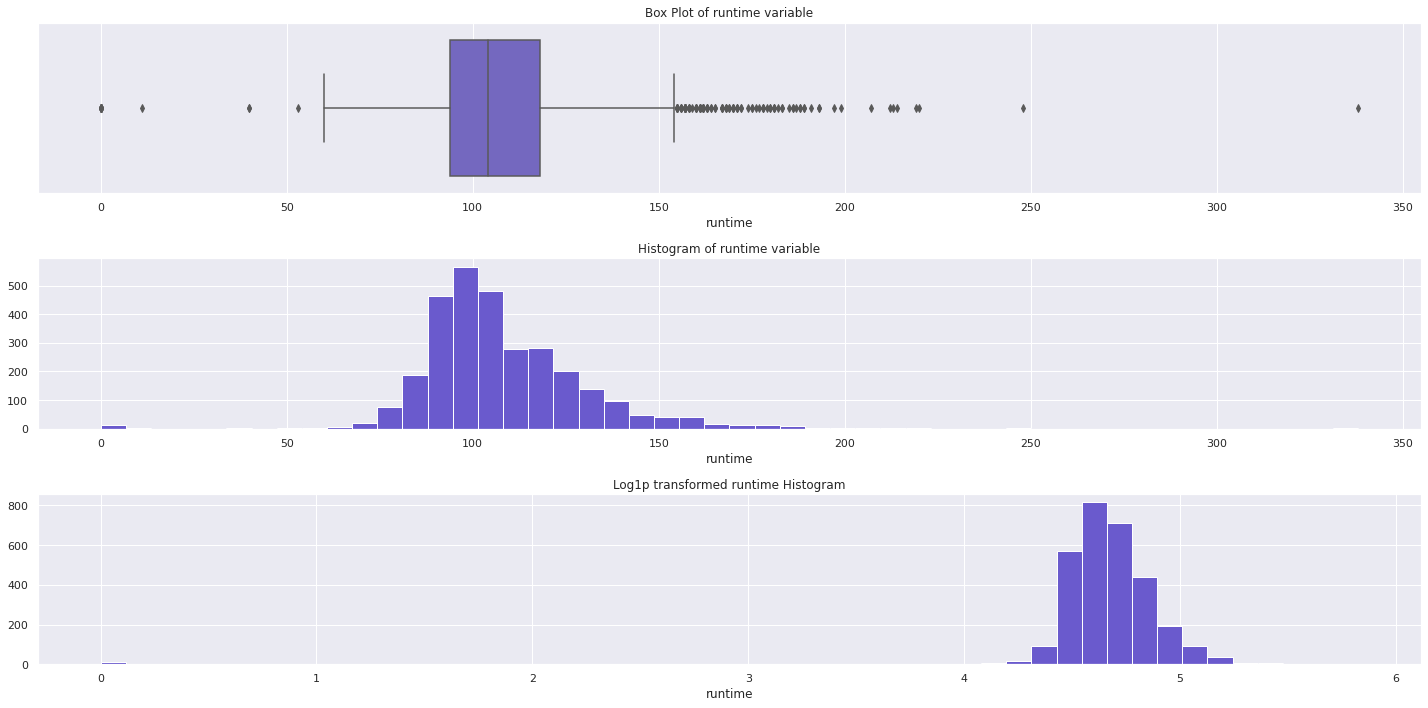

In [241]:
f, ax = plt.subplots(3, figsize=(20,10))

sns.set(rc={'figure.figsize':(20,8)})
sns.boxplot(x=train.runtime, ax = ax[0], color='slateblue')
ax[0].set_title("Box Plot of runtime variable")
sns.distplot(a=train.runtime, kde = False, ax = ax[1], color='slateblue', hist_kws=dict(alpha=1))
ax[1].set_title("Histogram of runtime variable")
sns.distplot(a=np.log1p(train.runtime), kde = False, ax = ax[2], color='slateblue', hist_kws=dict(alpha=1))
ax[2].set_title("Log1p transformed runtime Histogram")
f.tight_layout()

In [244]:
#전체적으로 비슷하지만 상영시간이 350분정도 되는 영화가 있는데 이상치인지 확인.

In [242]:
train.loc[train['runtime'].argmax(), ['title', 'runtime', 'revenue']]

title      Carlos
runtime       338
revenue    871279
Name: 1211, dtype: object

In [243]:
#영화의 이름은 까를로스 이상치는 아니지만 데이터 학습에 좋지않아 제거합니다.
train = train.drop(train['runtime'].argmax())

In [245]:
print('상영시간이 0인 데이터 개수: ',(train.runtime == 0).sum())

상영시간이 0인 데이터 개수:  12


In [246]:
#중간값으로 대체
median = train.loc[train['runtime'] > 0, 'runtime'].median()
train["runtime_processed"] = train["runtime"].mask(train["runtime"] == 0, median)
test["runtime_processed"] = test["runtime"].mask(test["runtime"] == 0, median)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


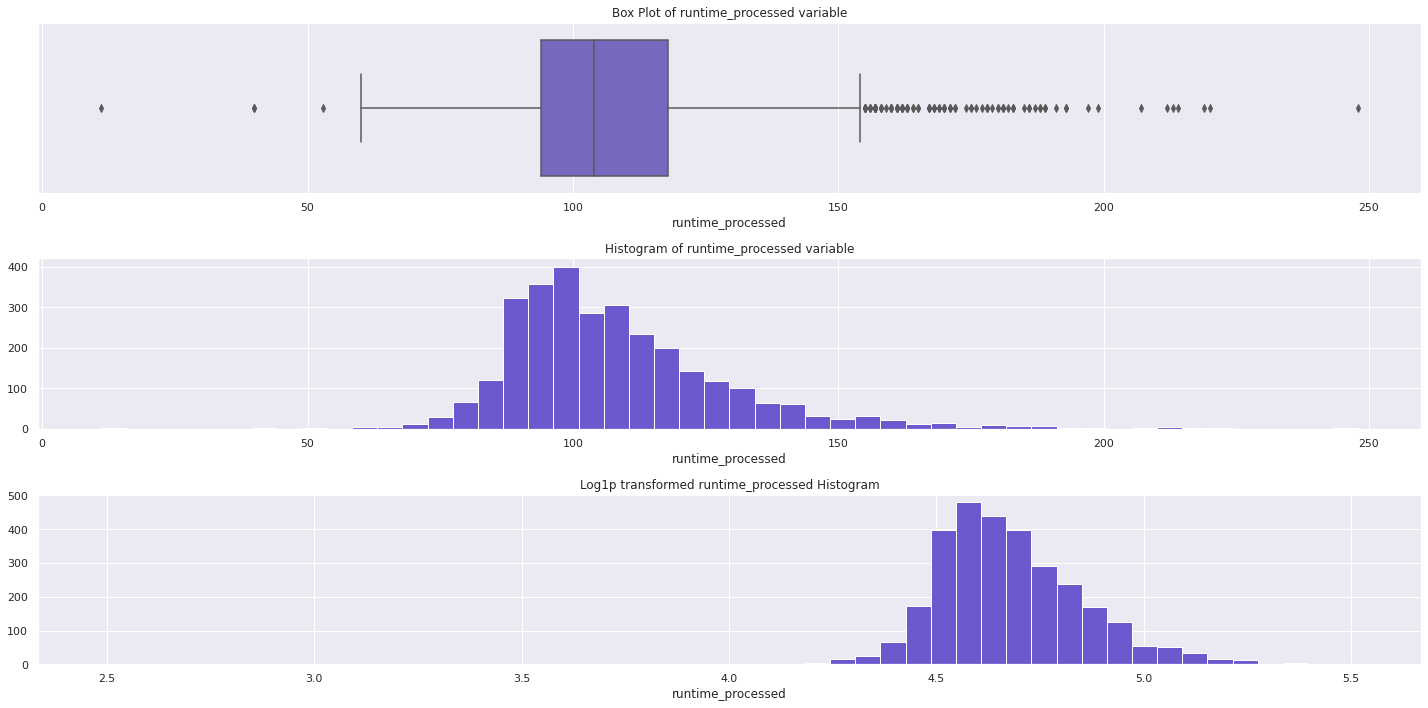

In [247]:
f, ax = plt.subplots(3, figsize=(20,10))

sns.set(rc={'figure.figsize':(20,8)})
sns.boxplot(x=train.runtime_processed, ax = ax[0], color='slateblue')
ax[0].set_title("Box Plot of runtime_processed variable")
sns.distplot(a=train.runtime_processed, kde = False, ax = ax[1], color='slateblue', hist_kws=dict(alpha=1))
ax[1].set_title("Histogram of runtime_processed variable")
sns.distplot(a=np.log1p(train.runtime_processed), kde = False, ax = ax[2], color='slateblue', hist_kws=dict(alpha=1))
ax[2].set_title("Log1p transformed runtime_processed Histogram")
f.tight_layout()

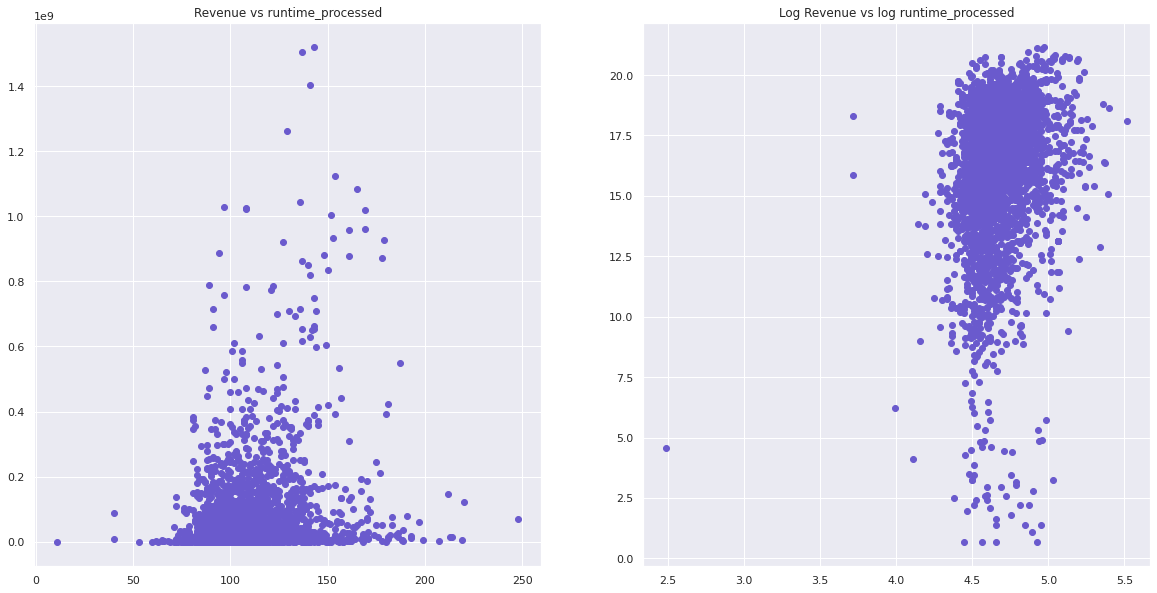

In [248]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.scatter(train['runtime_processed'], train['revenue'], color='slateblue')
plt.title('Revenue vs runtime_processed');
plt.subplot(1, 2, 2)
plt.scatter(np.log1p(train['runtime_processed']), np.log1p(train['revenue']), color='slateblue')
plt.title('Log Revenue vs log runtime_processed');

In [250]:
corr, _ = pearsonr(train['runtime_processed'], train['revenue'])
print('상관관계: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['runtime_processed']), np.log1p(train['revenue']))
print('로그 변환 후 상관관계: %.3f' % corr)

상관관계: 0.226
로그 변환 후 상관관계: 0.227


In [251]:
log_features.append('runtime_processed')

In [252]:
#음성언어는 위에서 데이터 분석한 영화언어와 비슷하게 진행

In [253]:
train['spoken_languages'].head(10)

0             [{'iso_639_1': 'en', 'name': 'English'}]
1             [{'iso_639_1': 'en', 'name': 'English'}]
2             [{'iso_639_1': 'en', 'name': 'English'}]
3    [{'iso_639_1': 'en', 'name': 'English'}, {'iso...
4             [{'iso_639_1': 'ko', 'name': '한국어/조선말'}]
5             [{'iso_639_1': 'en', 'name': 'English'}]
6             [{'iso_639_1': 'en', 'name': 'English'}]
7    [{'iso_639_1': 'ar', 'name': 'العربية'}, {'iso...
8             [{'iso_639_1': 'en', 'name': 'English'}]
9             [{'iso_639_1': 'en', 'name': 'English'}]
Name: spoken_languages, dtype: object

In [254]:
train.spoken_languages = train.spoken_languages.fillna("")
train['spoken_languages_reform'] = train['spoken_languages'].apply(lambda x: re.findall("'name': \'(.+?)\'", x))
train['num_languages'] = train.spoken_languages_reform.apply(lambda x: len(x))
print(train['num_languages'])


test.spoken_languages = test.spoken_languages.fillna("")
test['spoken_languages_reform'] = test['spoken_languages'].apply(lambda x: re.findall("'name': \'(.+?)\'", x))
test['num_languages'] = test.spoken_languages_reform.apply(lambda x: len(x))
print(test['num_languages'])

0       1
1       1
2       1
3       2
4       1
       ..
2995    1
2996    1
2997    1
2998    1
2999    1
Name: num_languages, Length: 2999, dtype: int64
0       2
1       1
2       1
3       3
4       1
       ..
4393    5
4394    1
4395    1
4396    1
4397    1
Name: num_languages, Length: 4398, dtype: int64


In [255]:
print(train.num_languages.describe())

count    2999.000000
mean        1.440814
std         0.872691
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         9.000000
Name: num_languages, dtype: float64


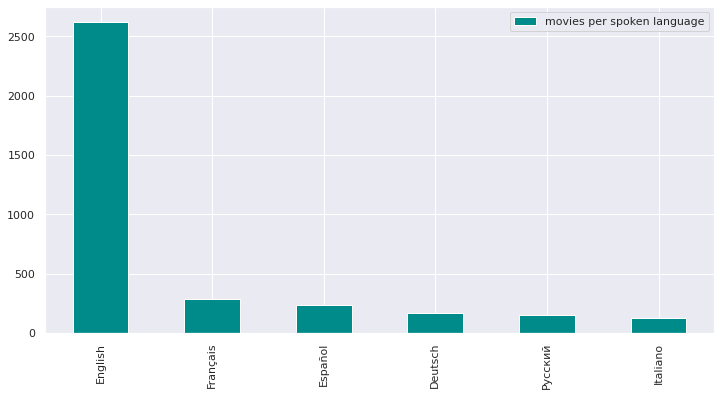

In [256]:
#시각화
languagesDict = {}
for element in train["spoken_languages_reform"].values:
    for name in element:
        if name not in languagesDict:
            languagesDict[name] = 1
        else:
            languagesDict[name] += 1
            
sns.set(rc={'figure.figsize':(12,6)})
            
languages_train = pd.DataFrame.from_dict(languagesDict, orient='index', columns=["movies per spoken language"])
languages_train.sort_values(by="movies per spoken language", ascending=False).head(6).plot.bar(color='darkcyan')

languages_train.columns = ["number_of_languages"]

In [257]:
#영어권 시장이 크기때문에 일수 있지만 전체적인 시장이 크기때문에 영어가 언어가 아닌 국가에서 팔리지 않습니다. 따라서, 영어가 아닌 경우 매출에 영향이 갑니다.

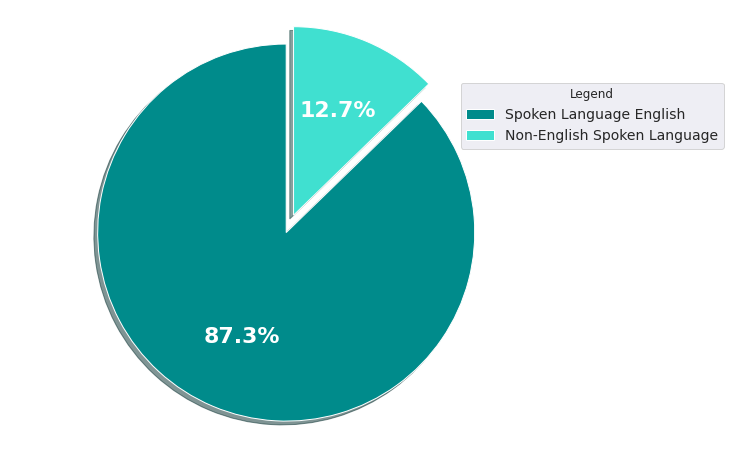

In [258]:
train['released_in_english'] = train['spoken_languages_reform'].apply(lambda x: 1 if 'English' in x else 0)
test['released_in_english'] = test['spoken_languages_reform'].apply(lambda x: 1 if 'English' in x else 0)

lang = [(train.released_in_english == 1).sum(axis=0), (train.released_in_english == 0).sum(axis=0)]
lang_test = [(test.released_in_english == 1), (test.released_in_english == 0).sum(axis=0)]

labels = 'Spoken Language English', 'Non-English Spoken Language'
explode = (0.1, 0)

# plot
colors = ["darkcyan", "turquoise"]

fig, ix = plt.subplots(figsize=(10, 8))
ix.pie(lang, explode=explode, autopct='%1.1f%%', shadow=True, startangle=90, colors=colors, textprops={'color':"w", 'fontsize':22, 'weight':"bold"})
ix.axis('equal')

ix.legend(labels,
          title="Legend",
          loc="center left",
          fontsize=14,
          bbox_to_anchor=(0.8, 0.25, 0.5, 1))

In [261]:
#영어인 영화가 87.3%입니다.

In [262]:
corr, _ = pearsonr(train['released_in_english'], train['revenue'])
print('released_in_english and revenue: %.3f' % corr)
corr, _ = pearsonr(train['released_in_english'], np.log1p(train['revenue']))
print('released_in_english and log transformed  revenue: %.3f' % corr)

released_in_english and revenue: 0.135
released_in_english and log transformed  revenue: 0.229


In [263]:
corr, _ = pearsonr(train['num_languages'], train['revenue'])
print('num_languages and revenue: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['num_languages']), np.log1p(train['revenue']))
print('log transformed num_languages and log transformed  revenue: %.3f' % corr)

num_languages and revenue: 0.067
log transformed num_languages and log transformed  revenue: 0.124


In [264]:
train_features.append('released_in_english')
log_features.append('num_languages')

In [265]:
#데이터 제외
cols_to_drop.append('status')

In [266]:
#영화에 대한 짧은설명이 수익에 영향을 미치는가?

In [267]:
train.tagline.head(10)

0    The Laws of Space and Time are About to be Vio...
1    It can take a lifetime to find true love; she'...
2      The road to greatness can take you to the edge.
3                                                  NaN
4                                                  NaN
5                                                  NaN
6                 Fear The Demon That Doesn't Fear God
7                Different channels. Different truths.
8                          Set sail for Muppet mayhem!
9             Back together for the first time, again.
Name: tagline, dtype: object

In [268]:
print('결측치:', train.tagline.isna().sum())

결측치: 597


In [269]:
#tagline 유무로만 판단.
train['has_tagline'] = train.tagline.apply(lambda x: 1 if type(x) == str else 0)
test['has_tagline'] = test.tagline.apply(lambda x: 1 if type(x) == str else 0)

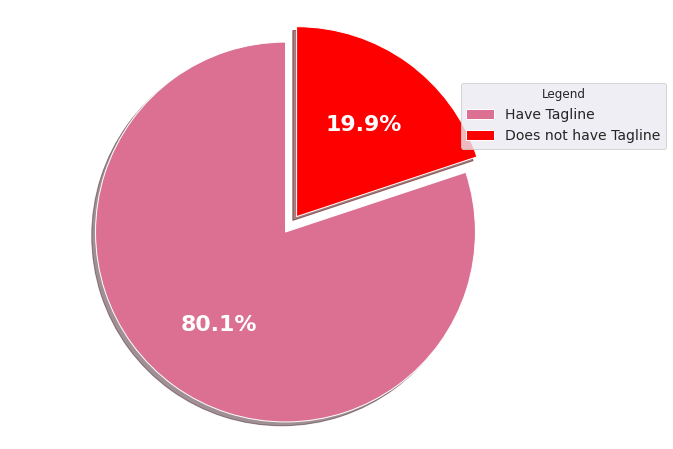

In [276]:
#시각화
labels = 'Have Tagline', 'Does not have Tagline'
btc_1 = [(train.has_tagline == 1).sum(axis=0), (train.has_tagline == 0).sum(axis=0)]
explode = (0.1, 0)

colors = ['palevioletred', 'red']

# plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.pie(btc_1, explode=explode, autopct='%1.1f%%', shadow=True, startangle=90, colors=colors, textprops={'color':"w", 'fontsize': 22, 'weight':"bold"})
ax.axis('equal') # ensures chart is a circle

ax.legend(labels,
          title="Legend",
          loc="center left",
          fontsize=14,
          bbox_to_anchor=(0.8, 0.25, 0.5, 1))

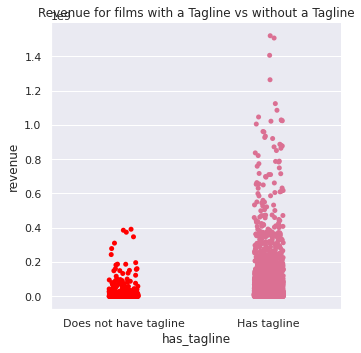

In [275]:
pal4 = ['red', 'palevioletred']

ax = sns.catplot(x='has_tagline', y='revenue', data=train, palette=pal4);
plt.title('Revenue for films with a Tagline vs without a Tagline');

labels = 'Does not have tagline', 'Has tagline'
ax.set_xticklabels(labels)

In [277]:
corr, _ = pearsonr(train['has_tagline'], train['revenue'])
print('have_tagline and revenue: %.3f' % corr)
corr, _ = pearsonr(train['has_tagline'], np.log1p(train['revenue']))
print('have_tagline and log transformed revenue: %.3f' % corr)

have_tagline and revenue: 0.180
have_tagline and log transformed revenue: 0.320


In [279]:
train_features.append('has_tagline')

In [281]:
cols_to_drop.append('title')
cols_to_drop.append('keywords')

In [282]:
#배우에 따라 캐릭터에 따라 수익률변화 상관관계분석
train.cast.head(10)

0    [{'cast_id': 4, 'character': 'Lou', 'credit_id...
1    [{'cast_id': 1, 'character': 'Mia Thermopolis'...
2    [{'cast_id': 5, 'character': 'Andrew Neimann',...
3    [{'cast_id': 1, 'character': 'Vidya Bagchi', '...
4    [{'cast_id': 3, 'character': 'Chun-soo', 'cred...
5    [{'cast_id': 6, 'character': 'Pinocchio (voice...
6    [{'cast_id': 23, 'character': 'Clyde', 'credit...
7    [{'cast_id': 2, 'character': 'Himself', 'credi...
8    [{'cast_id': 1, 'character': 'Long John Silver...
9    [{'cast_id': 24, 'character': 'Jonathan Steinb...
Name: cast, dtype: object

In [283]:
#전처리과정
print('결측치:',train.cast.isna().sum())

결측치: 13


In [284]:
train.cast = train.cast.fillna("")
train['cast_processed'] = train['cast'].apply(lambda x: re.findall("'name': \'(.+?)\'", x))
test.cast = test.cast.fillna("")
test['cast_processed'] = test['cast'].apply(lambda x: re.findall("'name': \'(.+?)\'", x))

In [285]:
train['num_cast'] = train['cast_processed'].apply(lambda x: len(x))
test['num_cast'] = test['cast_processed'].apply(lambda x: len(x))
train['num_cast'].value_counts()

15     204
16     158
10     136
14     133
13     129
      ... 
104      1
102      1
98       1
94       1
124      1
Name: num_cast, Length: 105, dtype: int64

In [286]:
median = train.loc[train['num_cast']> 0, 'num_cast'].median()
train["num_cast"] = train["num_cast"].mask(train["num_cast"] == 0, median)
test["num_cast"] = test["num_cast"].mask(test["num_cast"] == 0, median)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


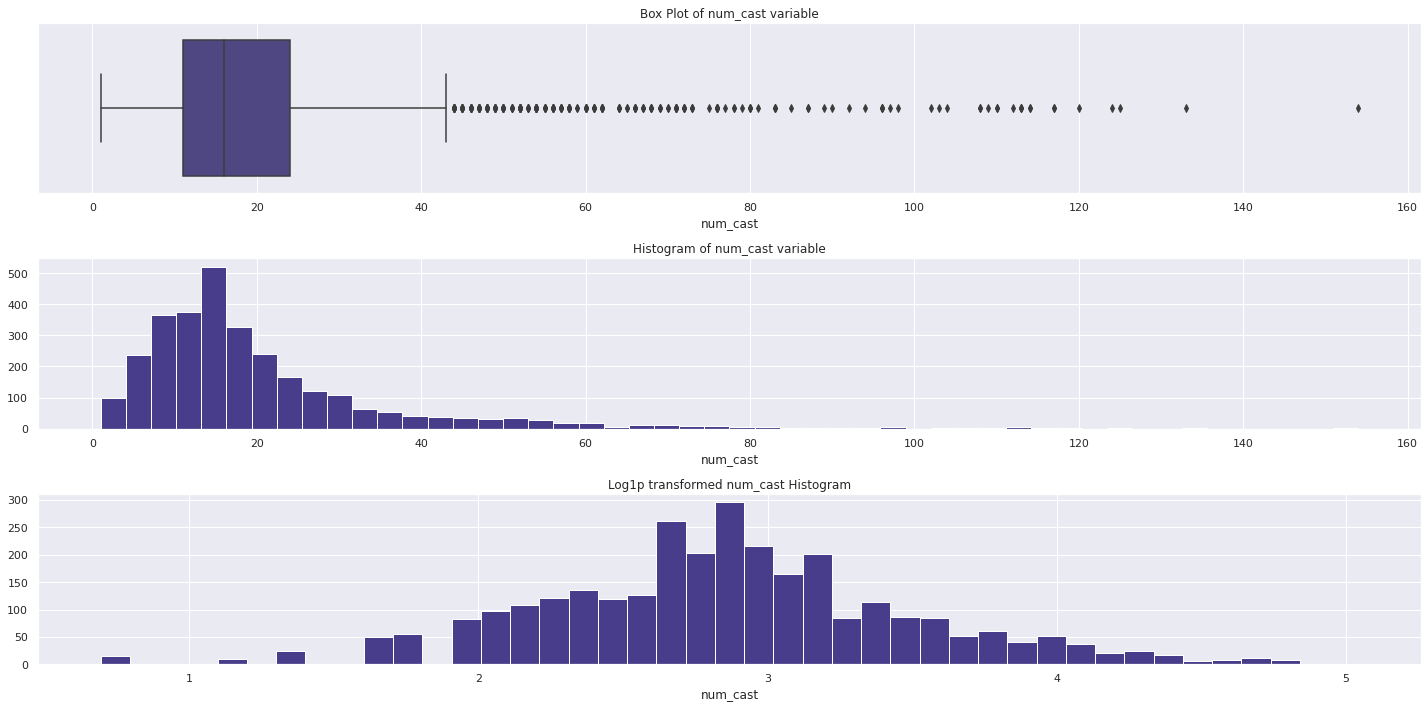

In [288]:
f, ax = plt.subplots(3, figsize=(20,10))

sns.set(rc={'figure.figsize':(18,8)})
sns.boxplot(x=train.num_cast, ax = ax[0], color='darkslateblue')
ax[0].set_title("Box Plot of num_cast variable")
sns.distplot(a=train.num_cast, kde = False, ax = ax[1], color='darkslateblue', hist_kws=dict(alpha=1))
ax[1].set_title("Histogram of num_cast variable")
sns.distplot(a=np.log1p(train.num_cast), kde = False, ax = ax[2], color='darkslateblue', hist_kws=dict(alpha=1))
ax[2].set_title("Log1p transformed num_cast Histogram")
f.tight_layout()

In [292]:
#배우별 수익 분석

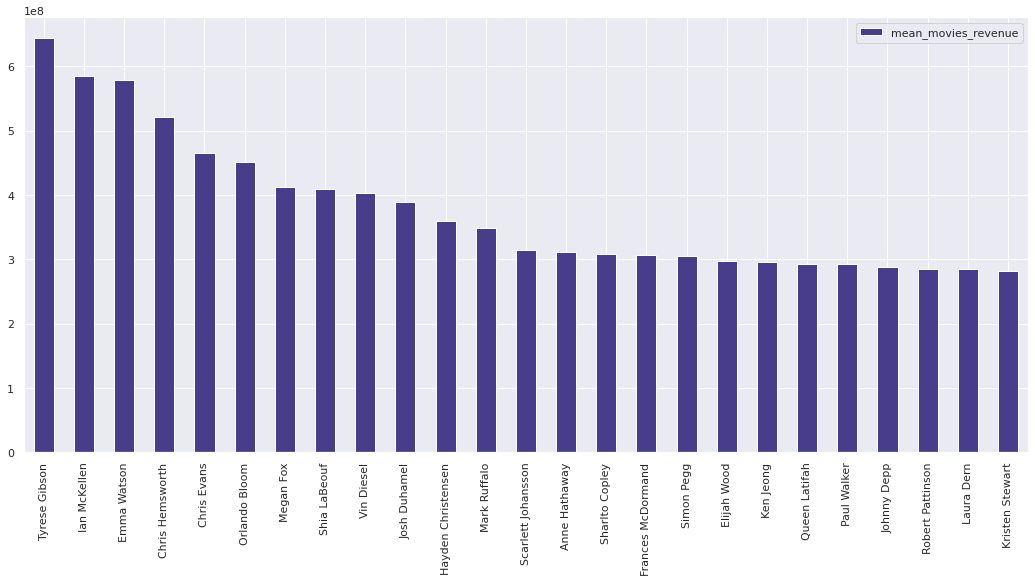

In [293]:
actorsDict = {}
for element in train[["revenue", "cast_processed"]].values:
    temp = 5
    if len(element[1]) < temp:
        temp = len(element[1])
    for i in range(temp):
        if element[1][i] not in actorsDict:
            actorsDict[element[1][i]] = [element[0], 1]
        else:
            actorsDict[element[1][i]][0] += element[0]
            actorsDict[element[1][i]][1] += 1    

actorsDict = {k: v for k, v in actorsDict.items() if v[1] >= 5}

for actor in actorsDict:
    actorsDict[actor][0] = actorsDict[actor][0]/actorsDict[actor][1]
    actorsDict[actor] = actorsDict[actor][0]


    
    
actors_train = pd.DataFrame.from_dict(actorsDict, orient='index', columns=["mean_movies_revenue"])
actors_train.sort_values(by="mean_movies_revenue", ascending=False).head(25).plot.bar(color='darkslateblue')

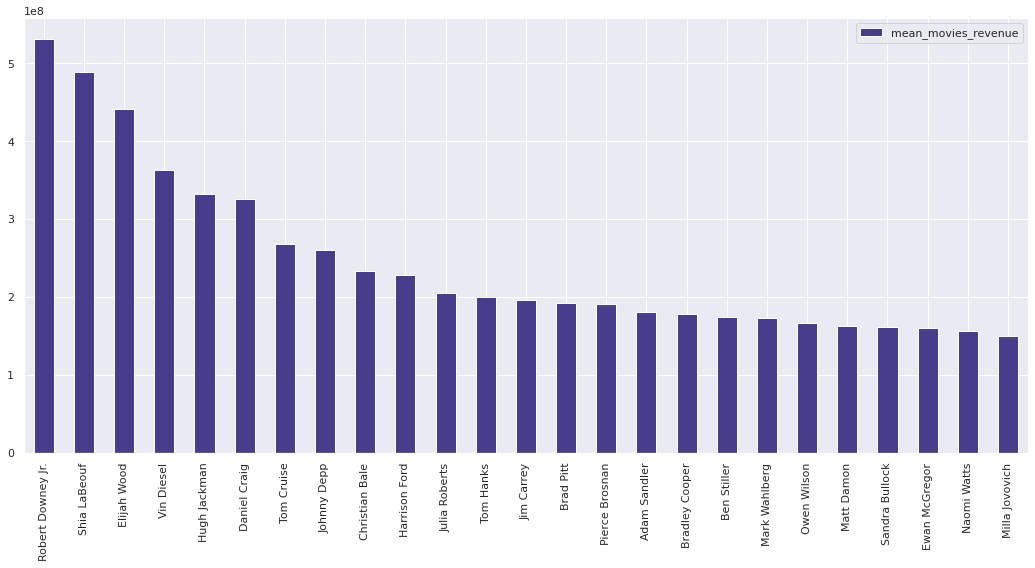

In [294]:
leadActorsDict = {}
for element in train[["revenue", "cast_processed"]].values:
   # compare results when looking at x top actors in films vs whole cast 
    temp = 1
    if len(element[1]) < temp:
        temp = len(element[1])
    for i in range(temp):
        if element[1][i] not in leadActorsDict:
            leadActorsDict[element[1][i]] = [element[0], 1]
        else:
            leadActorsDict[element[1][i]][0] += element[0]
            leadActorsDict[element[1][i]][1] += 1 

leadActorsDict = {k: v for k, v in leadActorsDict.items() if v[1] >= 5}

for actor in leadActorsDict:
    leadActorsDict[actor][0] = leadActorsDict[actor][0]/leadActorsDict[actor][1]
    leadActorsDict[actor] = leadActorsDict[actor][0]


    
    
actors_train = pd.DataFrame.from_dict(leadActorsDict, orient='index', columns=["mean_movies_revenue"])
actors_train.sort_values(by="mean_movies_revenue", ascending=False).head(25).plot.bar(color='darkslateblue')

In [295]:
#상위배우 액터와 주연 정렬
leadActorsDict = {k: v for k, v in sorted(leadActorsDict.items(), key=lambda item: item[1], reverse = True)}
actorsDict = {k: v for k, v in sorted(actorsDict.items(), key=lambda item: item[1], reverse = True)}


In [296]:
#주연이 톱 배우일경우
def checkLeadActor(cast):
    if len(cast) < 1 or cast[0] not in list(leadActorsDict)[:50]:
        return 0
    else:
        return 1

def checkTopActors(cast):
    if len(cast) < 1:
        return 0
    count = 0
    for actor in cast[:10]:
        if actor in list(actorsDict)[:100]:
            count += 1
    return count

def getActorRanks(cast):
    if len(cast) < 1:
        return len(actorsDict)
    rank = 0
    for a in cast[:5]:
        if a in list(actorsDict):
            rank += list(actorsDict.keys()).index(a)
    if rank == 0:
        rank = len(actorsDict)
    return rank / len(cast)

def getTopActorRank(cast):
    if len(cast) < 1:
        return len(leadActorsDict)
    if cast[0] in list(leadActorsDict):
        rank = list(leadActorsDict.keys()).index(cast[0])
    else:
        rank = len(leadActorsDict)
    return rank

#Creating a feature for top LEAD actors
train['topLeadActor'] = train['cast_processed'].apply(lambda x: checkLeadActor(x))
test['topLeadActor'] = test['cast_processed'].apply(lambda x: checkLeadActor(x))
#Creating feature for number of top actors
train['numTopActors'] = train['cast_processed'].apply(lambda x: checkTopActors(x))
test['numTopActors'] = test['cast_processed'].apply(lambda x: checkTopActors(x))


train['actorRanks'] = train['cast_processed'].apply(lambda x: getActorRanks(x))
test['actorRanks'] = test['cast_processed'].apply(lambda x: getActorRanks(x))

train['topActorRank'] = train['cast_processed'].apply(lambda x: getTopActorRank(x))
test['topActorRank'] = test['cast_processed'].apply(lambda x: getTopActorRank(x))

print(train['topLeadActor'].value_counts())
print()
print(train['numTopActors'].value_counts())
print()
print(train['actorRanks'].value_counts())
print()
print(train['topActorRank'].value_counts())

0    2557
1     442
Name: topLeadActor, dtype: int64

0    2272
1     520
2     143
3      40
4      15
5       5
6       3
7       1
Name: numTopActors, dtype: int64

40.200000     63
67.000000     62
60.300000     57
75.375000     55
46.384615     45
              ..
1.315789       1
18.578947      1
93.333333      1
25.454545      1
105.700000     1
Name: actorRanks, Length: 1944, dtype: int64

116    2116
48       18
29       16
42       15
30       14
       ... 
54        5
52        5
46        5
73        5
75        5
Name: topActorRank, Length: 117, dtype: int64


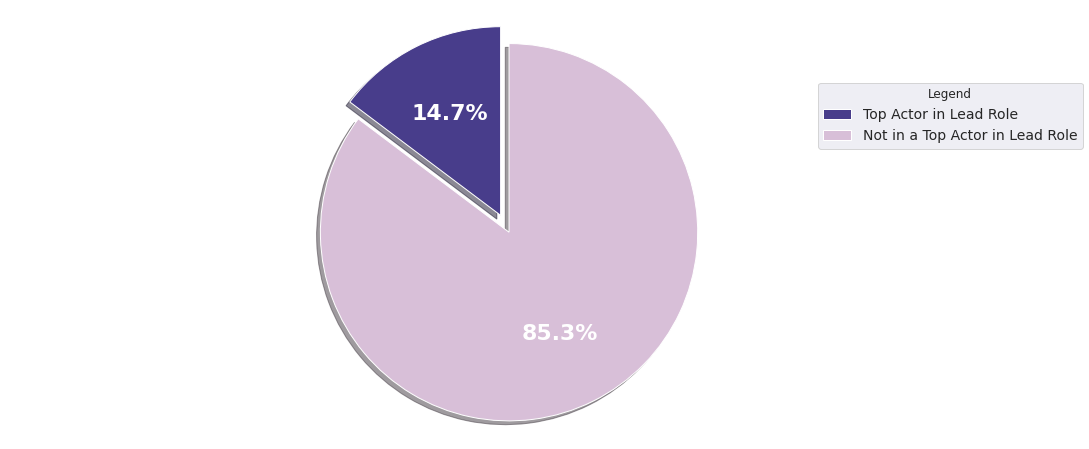

In [299]:
#시각화 
labels = 'Top Actor in Lead Role', 'Not in a Top Actor in Lead Role'
btc_1 = [sum(train.topLeadActor), (train.topLeadActor == 0).sum(axis=0)]
explode = (0.1, 0)

colors = ['darkslateblue', 'thistle']

fig, ax = plt.subplots()
plt.pie(btc_1, explode=explode, autopct='%1.1f%%', shadow=True, startangle=90, colors=colors, textprops={'color':"w", 'fontsize': 22, 'weight':"bold"})
plt.axis('equal') # ensures chart is a circle

ax.legend(labels,
          title="Legend",
          loc="center left",
          fontsize=14,
          bbox_to_anchor=(0.8, 0.25, 0.5, 1))


plt.show()

In [301]:
#상관관계분석

corr, _ = pearsonr(train['num_cast'], train['revenue'])
print(' num_cast and revenue: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['num_cast']), np.log1p(train['revenue']))
print('log transformed num_cast and  log transformed revenue: %.3f' % corr)
print()
corr, _ = pearsonr(train['topLeadActor'], train['revenue'])
print('topLeadActor and revenue: %.3f' % corr)
corr, _ = pearsonr(train['topLeadActor'], np.log1p((train['revenue'])))
print('topLeadActor and log transformed revenue: %.3f' % corr)
print()
corr, _ = pearsonr(train['numTopActors'], train['revenue'])
print('numTopActors and revenue: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['numTopActors']), np.log1p((train['revenue'])))
print('log transformed numTopActors and log transformed revenue: %.3f' % corr)
print()
corr, _ = pearsonr(train['actorRanks'], train['revenue'])
print('actorRanks and revenue: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['actorRanks']), np.log1p((train['revenue'])))
print('log transformed actorRanks and log transformed revenue: %.3f' % corr)
print()
corr, _ = pearsonr(train['topActorRank'], train['revenue'])
print('topActorRank and revenue: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['topActorRank']), np.log1p((train['revenue'])))
print('log transformed topActorRank and log transformed revenue: %.3f' % corr)

 num_cast and revenue: 0.345
log transformed num_cast and  log transformed revenue: 0.377

topLeadActor and revenue: 0.314
topLeadActor and log transformed revenue: 0.277

numTopActors and revenue: 0.578
log transformed numTopActors and log transformed revenue: 0.317

actorRanks and revenue: -0.115
log transformed actorRanks and log transformed revenue: -0.337

topActorRank and revenue: -0.323
log transformed topActorRank and log transformed revenue: -0.289


In [302]:
log_features.append('num_cast')
train_features.append('topLeadActor')
log_features.append('numTopActors')
log_features.append('actorRanks')
log_features.append('topActorRank')

In [304]:
#data 도출하기 어려워서 제외
cols_to_drop.append('crew')

In [305]:
#점수 올리기 위해 추가 데이터 엔지니어링

In [307]:
def getAvgStudioRev(movie):
    if movie.budget < 10000: 
        if len(movie.production_companies_reform) > 0:
            studios = movie.production_companies_reform
            median_revs = []
            for studio in studios:
                if studio in companies_df.index:
                     median_revs.append(float(companies_df.loc[studio]['median_rev']))
            if(len(median_revs) > 0) and mean(median_revs) > 10000:
                movie.budget_processed = mean(median_revs)
            else:
                movie.budget_processed = train.budget.median()
        else:
            movie.budget_processed = train.budget.median()
        
        
    
    if 'revenue' in movie and movie.revenue < 10000 and len(movie.production_companies_reform) > 0:
        studios = movie.production_companies_reform
        median_revs = []
        for studio in studios:
            if studio in companies_df.index:
                 median_revs.append(float(companies_df.loc[studio]['median_rev']))
        if(len(median_revs) > 0) and mean(median_revs) > 10000:
            movie.revenue = mean(median_revs)
        else:
            movie.revenue = train.revenue.median()
        return movie
    else:
        return movie

In [308]:
train = train.apply(getAvgStudioRev, axis=1)
test = test.apply(getAvgStudioRev, axis=1)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


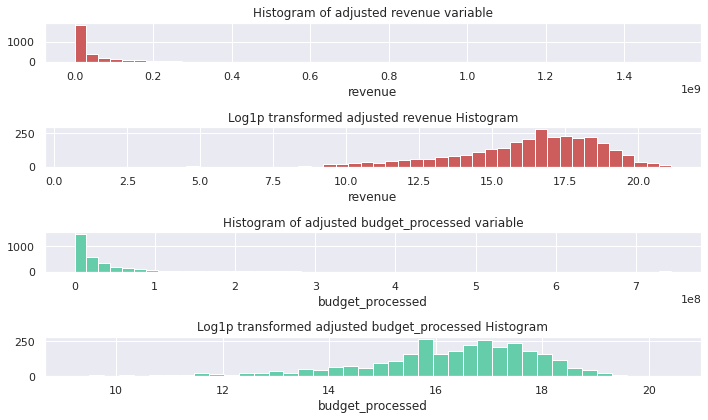

In [309]:
f, ax = plt.subplots(4, figsize=(10,6))

sns.set(rc={'figure.figsize':(12,8)})
sns.distplot(a=train.revenue, kde = False, ax = ax[0], color='indianred', hist_kws=dict(alpha=1))
ax[0].set_title("Histogram of adjusted revenue variable")
sns.distplot(a=np.log1p(train.revenue), kde = False, ax = ax[1], color='indianred', hist_kws=dict(alpha=1))
ax[1].set_title("Log1p transformed adjusted revenue Histogram")
sns.distplot(a=train.budget_processed, kde = False, ax = ax[2], color='mediumaquamarine', hist_kws=dict(alpha=1))
ax[2].set_title("Histogram of adjusted budget_processed variable")
sns.distplot(a=np.log1p(train.budget_processed), kde = False, ax = ax[3], color='mediumaquamarine', hist_kws=dict(alpha=1))
ax[3].set_title("Log1p transformed adjusted budget_processed Histogram")
f.tight_layout()

In [310]:
#조정후 데이터분포도가 더 좋아졌습니다.

In [311]:
#비율 계산

train['budget_to_year_ratio'] = train['budget_processed'] / (train['year'] * train['year'])
test['budget_to_year_ratio'] = test['budget_processed'] / (test['year'] * test['year'])

In [312]:
train['runtime_to_year_ratio'] = train['runtime'] / (train['year'])
test['runtime_to_year_ratio'] = test['runtime'] / (test['year'])


In [313]:
log_features.append('budget_to_year_ratio')
log_features.append('runtime_to_year_ratio')

In [314]:
print(cols_to_drop)

['imdb_id', 'original_title', 'original_title', 'overview', 'original_title', 'overview', 'popularity', 'poster_path', 'status', 'title', 'title', 'keywords', 'crew', 'crew']


In [315]:
print(train_features)

['belongs_to_collection', 'has_homepage', 'originally_english', 'topStudio', 'usa_produced', '1960s', '1970s', '1980s', '1990s', '2000s', '2010s', 'mondayRelease', 'tuesdayRelease', 'wednesdayRelease', 'thursdayRelease', 'fridayRelease', 'saturdayRelease', 'sundayRelease', 'Winter', 'Fall', 'Spring', 'Summer', 'released_in_english', 'has_tagline', 'has_tagline', 'topLeadActor']


In [316]:
print(log_features)

['revenue', 'budget_processed', 'genre_rank', 'num_genres', 'numTopStudios', 'num_studios', 'studioRank', 'num_production_countries', 'runtime_processed', 'num_languages', 'num_cast', 'numTopActors', 'actorRanks', 'topActorRank', 'budget_to_year_ratio', 'runtime_to_year_ratio']


In [ ]:
#로그변환

In [317]:
for feat in log_features:
    train["log_" + feat] = np.log1p(train[feat])
    if feat is not "revenue":
        test["log_" + feat] = np.log1p(test[feat]) 
        train_features.append("log_" + feat)

In [318]:
print(train_features)
print()
print("Number of features: ", len(train_features))

['belongs_to_collection', 'has_homepage', 'originally_english', 'topStudio', 'usa_produced', '1960s', '1970s', '1980s', '1990s', '2000s', '2010s', 'mondayRelease', 'tuesdayRelease', 'wednesdayRelease', 'thursdayRelease', 'fridayRelease', 'saturdayRelease', 'sundayRelease', 'Winter', 'Fall', 'Spring', 'Summer', 'released_in_english', 'has_tagline', 'has_tagline', 'topLeadActor', 'log_budget_processed', 'log_genre_rank', 'log_num_genres', 'log_numTopStudios', 'log_num_studios', 'log_studioRank', 'log_num_production_countries', 'log_runtime_processed', 'log_num_languages', 'log_num_cast', 'log_numTopActors', 'log_actorRanks', 'log_topActorRank', 'log_budget_to_year_ratio', 'log_runtime_to_year_ratio']

Number of features:  41


In [ ]:
#모델에 대한 41 features 도출

Text(0.5, 1.0, 'Correlation between numerical features')

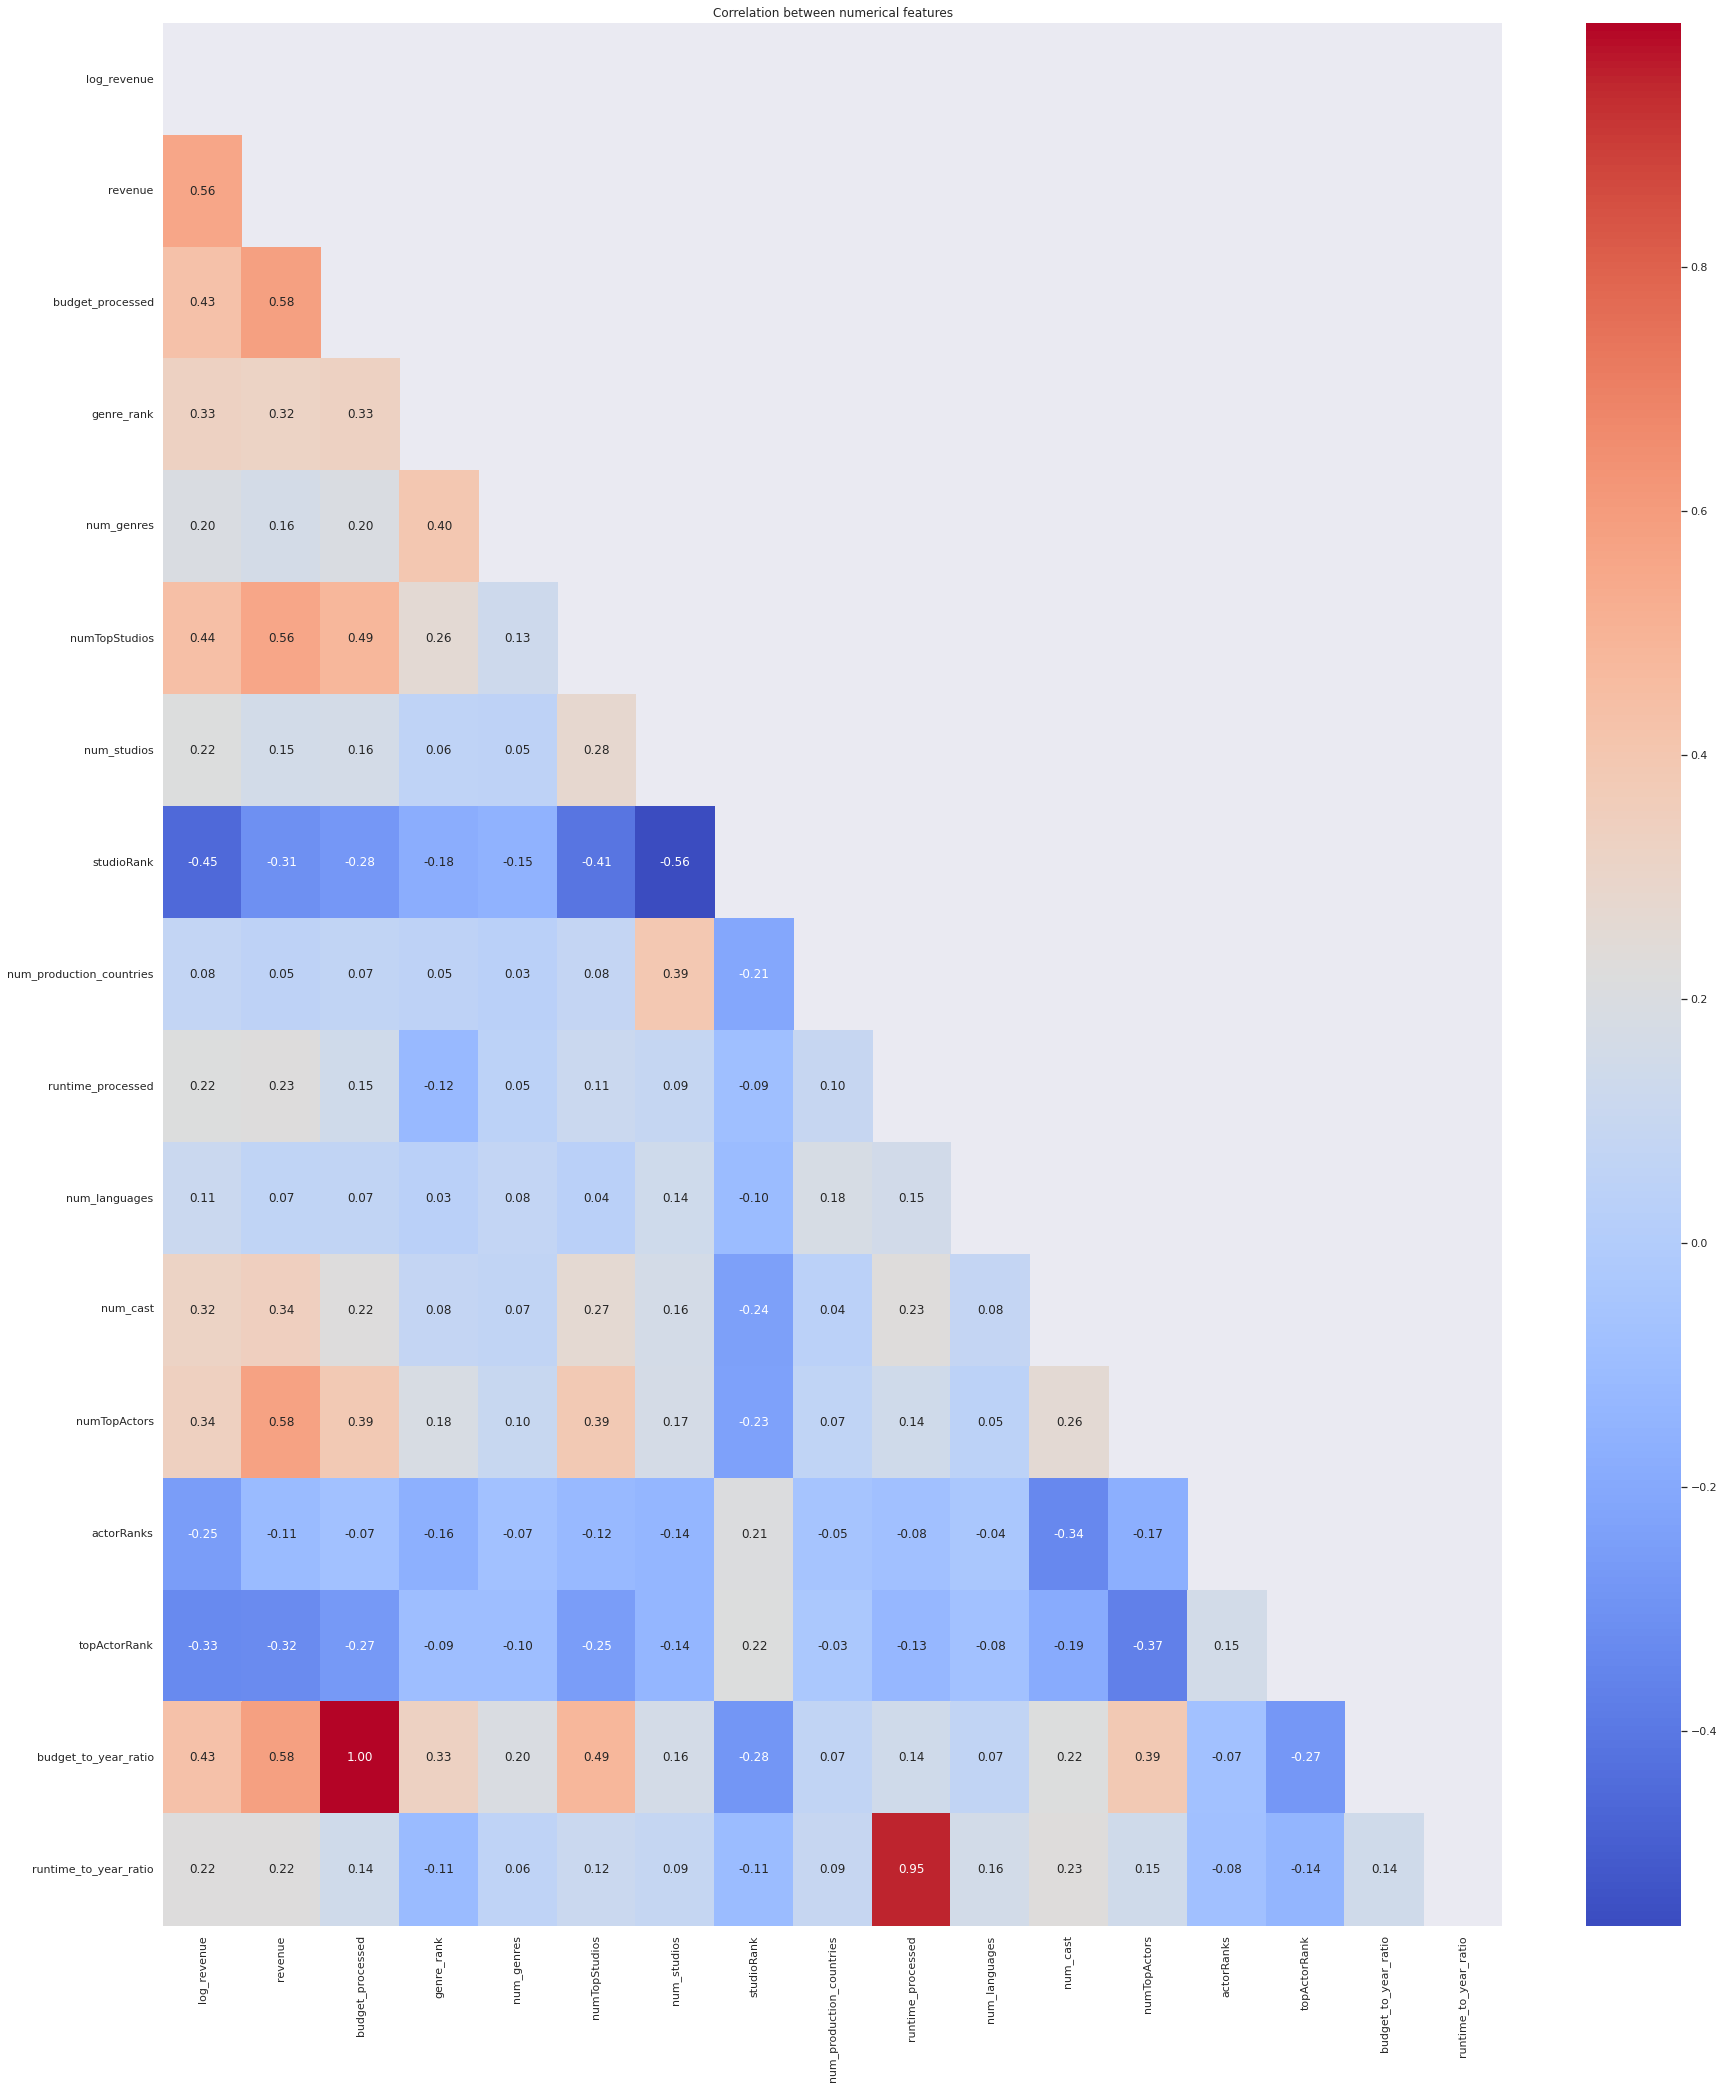

In [319]:
#모델에 대한 상관행렬
sns.set(rc={'figure.figsize':(30,35)})

# Compute the correlation matrix
corr = train[['log_revenue', *log_features]].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, mask=mask, 
            annot=True, 
            fmt=".2f", 
            cmap='coolwarm')

plt.title("Correlation between numerical features")

In [320]:
#데이터가 커 한눈에 들어오지 않지만 각 변수간의 상관관계를 볼수 있고 예산이 가장 상관 관계가 높은 항목 중 하나임을 알 수 있습니다

In [321]:
#Modeling train 80% ,test 20% (검증세트 비율)

In [322]:
X = train[train_features]
y = train['log_revenue']

In [323]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20)

In [324]:
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (2399, 41) (2399,)
Test set: (600, 41) (600,)


In [329]:
#여러 매트릭으로 출력해 모델의 성능을 판단함

In [330]:
#함수설정

In [325]:
def algorithm_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, 
                       model, param_grid, cv=10, scoring_fit='neg_root_mean_squared_error',
                       do_probabilities = False):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=2
    )
    fitted_model = gs.fit(X_train_data, y_train_data)
    
    if do_probabilities:
        pred = fitted_model.predict_proba(X_test_data)
    else:
        pred = fitted_model.predict(X_test_data)
    
    return fitted_model, pred

In [326]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Average Error: {:0.4f}'.format(np.mean(errors)))
    print('Accuracy = {:0.3f}%'.format(accuracy))
    
    return accuracy

In [328]:
def metrics(y_pred, y_test):
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    errors = abs(y_pred - y_test)
    mae = np.mean(errors)
    mape = 100 * (errors / y_test)
    print('Mean Squared Error: ', round(mse, 4))
    print('Root Mean Squared Error: ', round(rmse, 4))
    print('Mean Absolute Error: ', round(mae, 4))

    test_accuracy = 100 - np.mean(mape)
    print('Test Set Accuracy (from Mean Absolute Percentage Error):{:.3f}%'.format(test_accuracy))

In [336]:
#Random Forest
##Baseline 설정

rfr_base_model = RandomForestRegressor(random_state=42)
rfr_base_model.fit(X_train, y_train.values.ravel())

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [337]:
y_pred = rfr_base_model.predict(X_test)

In [338]:
errors = abs(np.expm1(y_pred) - np.expm1(y_test.values))
# MAE출력
print('Average Error:', round(np.mean(errors), 2))

Average Error: 34004707.83


In [339]:
print('Random Forest Baseline Model Metrics:')
metrics(y_pred, y_test.values)

Random Forest Baseline Model Metrics:
Mean Squared Error:  2.514
Root Mean Squared Error:  1.5856
Mean Absolute Error:  1.1012
Test Set Accuracy (from Mean Absolute Percentage Error):91.527%


In [340]:
#하이퍼파라미터 튜닝

param_grid = {
    'bootstrap': [True],
    'max_depth': [10, 25, 30],
    'max_features': [.4, 'auto'],
    'min_samples_leaf': [1, 2, 5],
    'min_samples_split': [1, 3, 5],
    'n_estimators': [100,400]
}

# base모델 설정
rfr = RandomForestRegressor(random_state=42)
# 그리드 검색 모델
rfr, pred = algorithm_pipeline(X_train, X_test, y_train.values.ravel(), y_test.values, rfr, 
                                 param_grid, cv=5)

# 평균제곱근오차
print(np.sqrt(-rfr.best_score_))
print(rfr.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  6.0min finished


1.2873704605612024
{'bootstrap': True, 'max_depth': 25, 'max_features': 0.4, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 400}


In [341]:
print('Base Model:')
base_accuracy = evaluate(rfr_base_model, X_test, y_test.values)
print()
print('Model after Tuning:')
rfr_best_model = rfr.best_estimator_
best_accuracy = evaluate(rfr_best_model, X_test, y_test.values)

print('Improvement of {:0.2f}%.'.format( 100 * (best_accuracy - base_accuracy) / base_accuracy))

Base Model:
Average Error: 1.1012
Accuracy = 91.527%

Model after Tuning:
Average Error: 1.0937
Accuracy = 91.580%
Improvement of 0.06%.


In [342]:
y_pred = rfr_best_model.predict(X_test)
print('Random Forest Model (After Tuning) Metrics:')
metrics(y_pred, y_test.values)

Random Forest Model (After Tuning) Metrics:
Mean Squared Error:  2.4713
Root Mean Squared Error:  1.572
Mean Absolute Error:  1.0937
Test Set Accuracy (from Mean Absolute Percentage Error):91.580%


In [343]:
#기능중요도

feature_importances = rfr_best_model.feature_importances_
indices = np.argsort(feature_importances)[::-1]

print("Feature ranking:")

for f in range(20):
    print("%d. %s (%f)" % (f + 1, X_train.columns[indices[f]], feature_importances[indices[f]]))

Feature ranking:
1. log_budget_to_year_ratio (0.239813)
2. log_budget_processed (0.201927)
3. topStudio (0.063996)
4. log_actorRanks (0.049872)
5. log_runtime_to_year_ratio (0.046333)
6. log_num_studios (0.045073)
7. log_studioRank (0.041983)
8. log_genre_rank (0.035542)
9. log_num_cast (0.035063)
10. log_runtime_processed (0.034890)
11. log_numTopStudios (0.034391)
12. log_topActorRank (0.018175)
13. belongs_to_collection (0.017164)
14. log_num_production_countries (0.013832)
15. log_num_genres (0.012111)
16. log_numTopActors (0.009090)
17. has_tagline (0.007106)
18. has_homepage (0.006786)
19. 2010s (0.006741)
20. mondayRelease (0.006473)


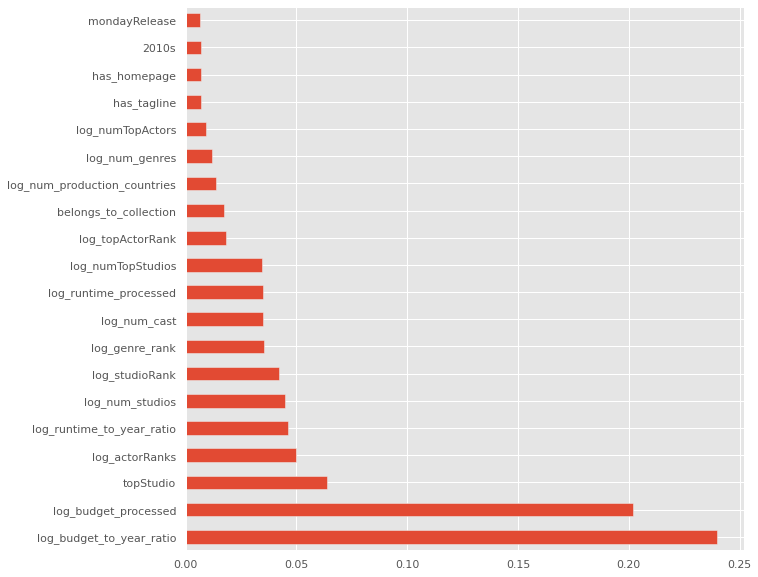

In [344]:
feat_importances = pd.Series(feature_importances, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh', figsize=[10,10])

In [345]:
# 예산및 연도별 예산 비율이 가장 중요했습니다.

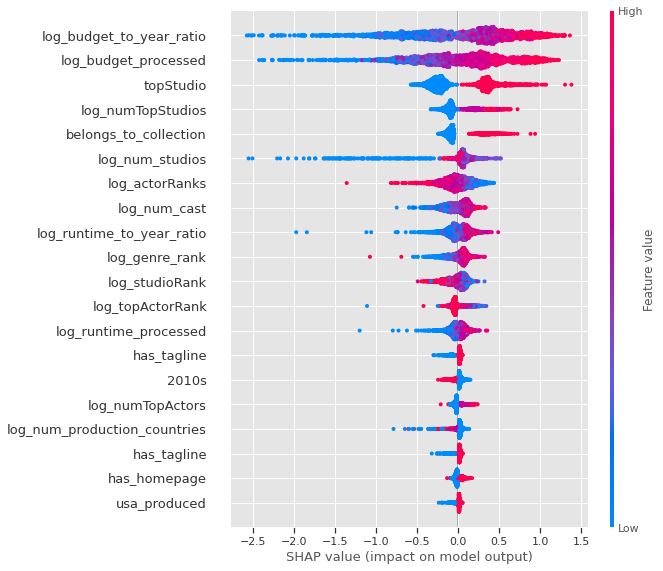

In [346]:
#SHAP값 분석

explainer = shap.TreeExplainer(rfr_best_model)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train)

In [347]:
#Extra Trees

#baseline
et_base_model = ExtraTreesRegressor(random_state = 42)
et_base_model.fit(X_train, y_train.values.ravel())

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=None, oob_score=False,
                    random_state=42, verbose=0, warm_start=False)

In [348]:
y_pred = et_base_model.predict(X_test)

In [349]:
print('Extra Trees Baseline Model Metrics:')
metrics(y_pred, y_test.values)

Extra Trees Baseline Model Metrics:
Mean Squared Error:  2.7868
Root Mean Squared Error:  1.6694
Mean Absolute Error:  1.1474
Test Set Accuracy (from Mean Absolute Percentage Error):91.178%


In [350]:
# Extra Trees  Hyperparameter Tuning

In [351]:
et_model = ExtraTreesRegressor(random_state = 42)
param_grid = {
    'bootstrap': [True],
    'max_depth': [35, 40, 45],
    'max_features': [.4, .6, 'auto'],
    'min_samples_leaf': [1, 2],
    'min_samples_split': [4, 5, 7],
    'n_estimators': [100, 250, 400]
}

et_model, pred = algorithm_pipeline(X_train, X_test, y_train.values.ravel(), y_test.values, et_model, 
                                 param_grid, cv=5)

# Root Mean Squared Error
print(np.sqrt(-et_model.best_score_))
print(et_model.best_params_)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed:  6.6min finished


1.2856193219640293
{'bootstrap': True, 'max_depth': 35, 'max_features': 0.4, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 400}


In [352]:
base_accuracy = evaluate(et_base_model, X_test, y_test.values)

et_best_model = et_model.best_estimator_
best_accuracy = evaluate(et_best_model, X_test, y_test.values)


print('Improvement of {:0.2f}%.'.format( 100 * (best_accuracy - base_accuracy) / base_accuracy))

Average Error: 1.1474
Accuracy = 91.178%
Average Error: 1.1003
Accuracy = 91.448%
Improvement of 0.30%.


In [ ]:
#정확도 91%

In [353]:
y_pred = et_best_model.predict(X_test)
print('Extra Trees Model (After Tuning) Metrics:')
metrics(y_pred, y_test.values)

Extra Trees Model (After Tuning) Metrics:
Mean Squared Error:  2.5767
Root Mean Squared Error:  1.6052
Mean Absolute Error:  1.1003
Test Set Accuracy (from Mean Absolute Percentage Error):91.448%


In [355]:
feature_importances = et_best_model.feature_importances_
indices = np.argsort(feature_importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(20):
    print("%d. %s (%f)" % (f + 1, X_train.columns[indices[f]], feature_importances[indices[f]]))

Feature ranking:
1. log_budget_to_year_ratio (0.146220)
2. log_budget_processed (0.138775)
3. topStudio (0.132082)
4. log_numTopStudios (0.045291)
5. log_num_studios (0.040850)
6. belongs_to_collection (0.029545)
7. log_runtime_processed (0.024659)
8. log_actorRanks (0.023986)
9. log_num_cast (0.023191)
10. log_runtime_to_year_ratio (0.022696)
11. log_studioRank (0.022400)
12. has_homepage (0.021583)
13. has_tagline (0.020716)
14. log_num_production_countries (0.020568)
15. log_genre_rank (0.020462)
16. has_tagline (0.020195)
17. log_numTopActors (0.018792)
18. log_topActorRank (0.014945)
19. log_num_genres (0.014778)
20. usa_produced (0.014410)


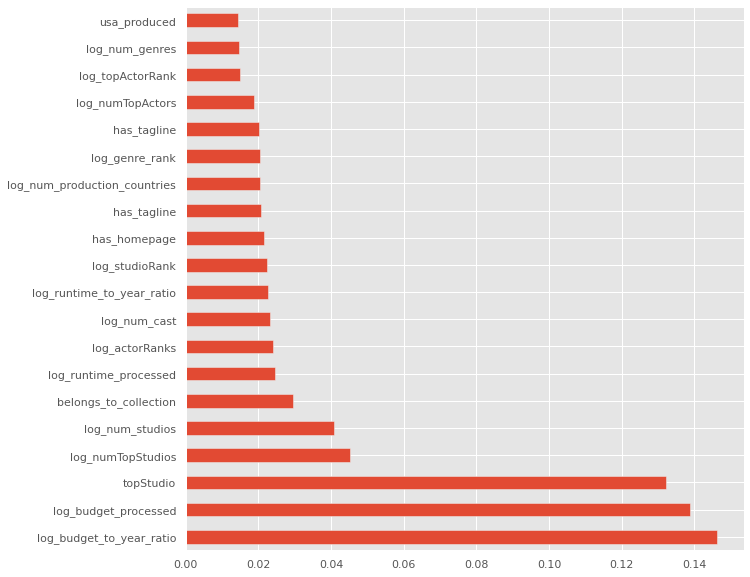

In [356]:
feat_importances = pd.Series(feature_importances, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh', figsize=[10,10])

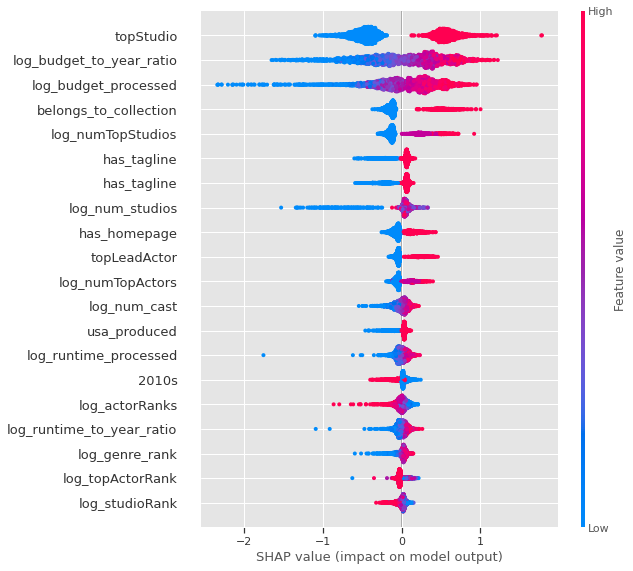

In [357]:
explainer = shap.TreeExplainer(et_best_model)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train)

In [ ]:
#Test set 예측 정확도 91%

In [359]:
#XGBOOST
xgb_base_model = xgb.XGBRegressor(random_state = 42)
xgb_base_model.fit(X_train, y_train.values.label())

AttributeError: ignored